In [1]:
import sys
#sys.path.insert(0,'/eos/home-a/antoniov/SWAN_projects/env/uproot4/lib/python3.7/site-packages')
sys.path.insert(0,'/eos/home-a/antoniov/SWAN_projects/env/uproot/lib/python3.8/site-packages')
print ( sys.path )

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import mplhep
from matplotlib.colors import LogNorm
from joblib import dump, load
plt.style.use(mplhep.style.CMS)

['/eos/home-a/antoniov/SWAN_projects/env/uproot/lib/python3.8/site-packages', '/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/python', '/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib', '', '/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.8.6-3199b/x86_64-centos7-gcc8-opt/lib/python38.zip', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.8.6-3199b/x86_64-centos7-gcc8-opt/lib/python3.8', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.8.6-3199b/x86_64-centos7-gcc8-opt/lib/python3.8/lib-dynload', '/eos/home-a/antoniov/SWAN_projects/env/uproot/lib/python3.8/site-packages', '/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/IPython/extensions', '/scratch/antoniov/.ipython']


In [2]:
# run_ranges_periods, df_run_ranges, fiducial_cuts, fiducial_cuts_all, aperture_period_map, aperture_parametrisation, check_aperture, get_data, process_data_protons_multiRP
from processing import *

save_figures = False

# test_sample_ratio = 0.40

run_tables = False

Welcome to JupyROOT 6.22/06
{'2017B': 2.360904801, '2017C1': 5.313012839, '2017C2': 3.264135878, '2017D': 4.074723964, '2017E': 8.958810514, '2017F1': 1.708478656, '2017F2': 7.877903151, '2017F3': 3.632463163}
Luminosity: 37.190432966


### Event selection

In [3]:
def select_events( df_events ):
    
    df_events.loc[ :, "deltaPhi_jet_muon"] = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, "muon0_phi"] )
    msk_dphi_ = ( df_events.loc[ :, "deltaPhi_jet_muon"] < -np.pi )
    df_events.loc[ :, "deltaPhi_jet_muon"].loc[ msk_dphi_ ] = df_events.loc[ :, "deltaPhi_jet_muon"].loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( df_events.loc[ :, "deltaPhi_jet_muon"] >= np.pi )
    df_events.loc[ :, "deltaPhi_jet_muon"].loc[ msk_dphi_ ] = df_events.loc[ :, "deltaPhi_jet_muon"].loc[ msk_dphi_ ] - 2*np.pi
    
    df_events.loc[ :, "deltaEta_jet_muon"] = ( df_events.loc[ :, "jet0_eta"] - df_events.loc[ :, "muon0_eta"] )
    df_events.loc[ :, "deltaR_jet_muon"] = np.sqrt( ( df_events.loc[ :, "deltaPhi_jet_muon"] ) ** 2 +
                                                    ( df_events.loc[ :, "deltaEta_jet_muon"] ) ** 2 )
    
    df_events.loc[ :, "deltaPhi_jet_met"] = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, "met_phi"] )
    msk_dphi_ = ( df_events.loc[ :, "deltaPhi_jet_met"] < -np.pi )
    df_events.loc[ :, "deltaPhi_jet_met"].loc[ msk_dphi_ ] = df_events.loc[ :, "deltaPhi_jet_met"].loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( df_events.loc[ :, "deltaPhi_jet_met"] >= np.pi )
    df_events.loc[ :, "deltaPhi_jet_met"].loc[ msk_dphi_ ] = df_events.loc[ :, "deltaPhi_jet_met"].loc[ msk_dphi_ ] - 2*np.pi
    
    df_events.loc[ :, "deltaPhi_jet_Wlep"] = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, "WLeptonicPhi"] )
    msk_dphi_ = ( df_events.loc[ :, "deltaPhi_jet_Wlep"] < -np.pi )
    df_events.loc[ :, "deltaPhi_jet_Wlep"].loc[ msk_dphi_ ] = df_events.loc[ :, "deltaPhi_jet_Wlep"].loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( df_events.loc[ :, "deltaPhi_jet_Wlep"] >= np.pi )
    df_events.loc[ :, "deltaPhi_jet_Wlep"].loc[ msk_dphi_ ] = df_events.loc[ :, "deltaPhi_jet_Wlep"].loc[ msk_dphi_ ] - 2*np.pi

    df_events.loc[ :, "jet0_tau21" ] = df_events.loc[ :, "jet0_tau2"] / df_events.loc[ :, "jet0_tau1"]
    
    df_events.loc[ :, "xiCMS_45" ] = ( 1. / 13000 ) * ( df_events.loc[ :, "WLeptonicPt" ] * np.exp( df_events.loc[ :, "WLeptonicEta" ] ) +
                                                        df_events.loc[ :, "jet0_pt" ] * np.exp( df_events.loc[ :, "jet0_eta" ] ) )
    df_events.loc[ :, "xiCMS_56" ] = ( 1. / 13000 ) * ( df_events.loc[ :, "WLeptonicPt" ] * np.exp( -df_events.loc[ :, "WLeptonicEta" ] ) +
                                                        df_events.loc[ :, "jet0_pt" ] * np.exp( -df_events.loc[ :, "jet0_eta" ] ) )

    msk_All_ = np.full( df_events.shape[0], True, dtype=bool )
    msk_muon_ = ( ( df_events.loc[ :, "muon0_pt"] >= 50.0 ) &
                  ( df_events.loc[ :, "muon0_eta"] <= 2.4 ) & 
                  ( df_events.loc[ :, "muon0_iso"] <= 0.10 ) )
    msk_jet_ = ( ( df_events.loc[ :, "jet0_pt"] >= 200.0 ) &
                 ( df_events.loc[ :, "jet0_eta"] <= 2.4 ) )
    msk_jet_muon_ = ( df_events.loc[ :, "deltaR_jet_muon"] >= np.pi/2 )
    msk_met_ = ( df_events.loc[ :, "met"] >= 40.0 )
    msk_jet_met_ = ( np.abs( df_events.loc[ :, "deltaPhi_jet_met"] ) >= 2.0 )
    msk_pruned_mass_ = ( ( df_events.loc[ :, "jet0_corrmass"] >= 50.0 ) &
                         ( df_events.loc[ :, "jet0_corrmass"] <= 110.0 ) )
    msk_tau21_       = ( df_events.loc[ :, "jet0_tau21"] <= 0.60 )
    msk_bjet_veto_   = ( df_events.loc[ :, "num_bjets_ak4"] == 0 )
#     msk_xiCMS_ = msk_All_.copy()
    msk_xiCMS_       = ( ( df_events.loc[ :, "xiCMS_45" ] <= 0.20 ) & ( df_events.loc[ :, "xiCMS_56" ] <= 0.20 ) )
    msk_Wlep_ = ( df_events.loc[ :, "WLeptonicPt"] >= 200.0 )
    msk_jet_Wlep_ = ( np.abs( df_events.loc[ :, "deltaPhi_jet_Wlep"] ) >= 2.5 )
    msk_MWW_ = ( df_events.loc[ :, "recoMWW"] >= 500.0 )
    msk_extra_tracks_ = ( df_events.loc[ :, "pfcand_nextracks" ] <= 4 )

    masks_ = [ msk_All_, msk_muon_, msk_jet_, msk_jet_muon_, msk_met_, msk_jet_met_,
               msk_pruned_mass_, msk_tau21_, msk_bjet_veto_, msk_xiCMS_,
               msk_Wlep_, msk_jet_Wlep_, msk_MWW_, msk_extra_tracks_ ]
    selection_keys_ = [ "All", "Muon", "Jet", "Jet_Muon", "MET", "Jet_MET",
                        "PrunedMass", "Tau21", "BJet_Veto", "Xi_CMS",
                        "WLeptonic", "Jet_WLeptonic", "MWW", "ExtraTracks" ]
    selections_ = {}
    msk_ = masks_[ 0 ].copy()
    for idx_, key_ in enumerate( selection_keys_ ):
        msk_ = msk_ & masks_[ idx_ ]
        selections_[ key_ ] = np.sum( msk_ )
        
    df_events = df_events.loc[ msk_ ]
    
    return df_events, selection_keys_, selections_

### Signal

In [270]:
#label = "GGToWW-AQGC-test-A0W1e-6"
#label = "GGToWW-AQGC-test-A0W2e-6"
#label = "GGToWW-AQGC-test-A0W5e-6"
labels_signals = [ "GGToWW-AQGC-A0W1e-6", "GGToWW-AQGC-A0W2e-6", "GGToWW-AQGC-A0W5e-6" ]

# fileNames_signal = [
#     #"output-GGToWW-AQGC-test-A0W1e-6.h5"
#     #"output-GGToWW-AQGC-test-A0W2e-6.h5"
#     "output-GGToWW-AQGC-test-A0W5e-6.h5"
# ]
fileNames_signals = {
    "GGToWW-AQGC-A0W1e-6": [ "output-GGToWW-AQGC-A0W1e-6.h5" ],
    "GGToWW-AQGC-A0W2e-6": [ "output-GGToWW-AQGC-A0W2e-6.h5" ],
    "GGToWW-AQGC-A0W5e-6": [ "output-GGToWW-AQGC-A0W5e-6.h5" ]
    }

df_counts_signals = {}
df_signals_protons_multiRP_index = {}
df_signals_protons_multiRP_events = {}

for label_ in labels_signals:
    import time
    print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
    time_s_ = time.time()

    #df_counts_signal, df_protons_multiRP_signal, df_protons_singleRP_signal, df_ppstracks_signal = 4 * [None]
    #df_protons_multiRP_signal_index, df_protons_multiRP_signal_events, df_ppstracks_signal_index = 3 * [None]

    if run_tables:
        with pd.HDFStore( "reduced-data-store-{}.h5".format( label_ ), complevel=5 ) as store_:

            df_counts_signal_, df_protons_multiRP_signal_, df_protons_singleRP_signal_, df_ppstracks_signal_ = get_data( fileNames_signals[ label_ ] )
            df_protons_multiRP_signal_index_, df_protons_multiRP_signal_events_, df_ppstracks_signal_index_ = process_data_protons_multiRP( df_protons_multiRP_signal_, df_ppstracks_signal_, apply_fiducial=True, select_2protons=False, runOnMC=True )

            store_[ "counts" ] = df_counts_signal_
            store_[ "protons_multiRP"] = df_protons_multiRP_signal_index_
            store_[ "events_multiRP" ] = df_protons_multiRP_signal_events_
    
    with pd.HDFStore( "reduced-data-store-{}.h5".format( label_ ), 'r' ) as store_:
        df_counts_signals[ label_ ] = store_[ "counts" ]
        df_signals_protons_multiRP_index[ label_ ] = store_[ "protons_multiRP" ]
        df_signals_protons_multiRP_events[ label_ ] = store_[ "events_multiRP" ]

    time_e_ = time.time()
    print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

2021/04/26 02:42:51
Total time elapsed: 0
2021/04/26 02:42:51
Total time elapsed: 0
2021/04/26 02:42:51
Total time elapsed: 1


In [267]:
label_ = "GGToWW-AQGC-A0W1e-6"
df_signals_protons_multiRP_index[ label_ ]

xi       thx       thy         t  ismultirp  \
run lumiblock event  slice                                                      
1   2266      226549 0      0.049396  0.000070  0.000006 -0.202391          1   
              226551 0      0.047449  0.000007  0.000021 -0.022129          1   
                     0      0.051457  0.000022  0.000089 -0.342805          1   
    2267      226605 0      0.129090  0.000042 -0.000010 -0.086362          1   
              226690 0      0.028568  0.000061 -0.000014 -0.162398          1   
    2268      226734 0      0.122175  0.000038 -0.000003 -0.068695          1   
              226716 0      0.164051 -0.000072 -0.000019 -0.226659          1   
              226773 0      0.044415 -0.000016  0.000041 -0.081292          1   
    2270      226932 0      0.032306  0.000006 -0.000075 -0.234367          1   
                     0      0.119526 -0.000012  0.000005 -0.020655          1   
    2273      227227 0      0.056667 -0.000025 -0.000072 -0.233687          1   
                     0      0.053138 -0.000011 -0.000024 -0.030825          1   
    2274      227321 0      0.082597  0.000042 -0.000018 -0.086781          1   
              227328 0      0.141799 -0.000062  0.000005 -0.161479          1   
              227324 0      0.057238 -0.000019  0.000045 -0.099979          1   
    2275      227457 0      0.068920 -0.000051  0.000024 -0.129756          1   
                     0      0.115064  0.000022  0.000018 -0.042887          1   
    2276      227546 0      0.090561 -0.000041  0.000076 -0.292089          1   
                     0      0.125299 -0.000021  0.000054 -0.142210          1   
              227579 0      0.118551 -0.000022 -0.000012 -0.037683          1   
                     0      0.169634 -0.000121 -0.000032 -0.583498          1   
    2277      227611 0      0.037509  0.000041  0.000004 -0.071968          1   
              227610 0      0.088627 -0.000125 -0.000004 -0.614065          1   
              227661 0      0.057884  0.000036  0.000051 -0.158605          1   
    2278      227745 0      0.084094 -0.000080 -0.000087 -0.548091          1   
    2279      227825 0      0.067304 -0.000003  0.000013 -0.011687          1   
              227868 0      0.062334  0.000017  0.000011 -0.020236          1   
    2280      227969 0      0.085506  0.000025  0.000011 -0.035329          1   
    2281      228042 0      0.105618  0.000070  0.000014 -0.202386          1   
                     0      0.128394  0.000116  0.000039 -0.572105          1   
...                              ...       ...       ...       ...        ...   
    9019      401874 0      0.033579 -0.000103 -0.000091 -0.770512          1   
                     0      0.084197  0.000007  0.000073 -0.213555          1   
    9021      402066 0      0.036611  0.000072  0.000042 -0.282051          1   
                     0      0.046874  0.000018  0.000021 -0.032829          1   
              402070 0      0.042629  0.000002  0.000039 -0.065000          1   
              402092 0      0.102647 -0.000046  0.000074 -0.302056          1   
    9024      402306 0      0.101640  0.000058  0.000090 -0.444098          1   
              402311 0      0.108578 -0.000074  0.000040 -0.278426          1   
              402331 0      0.107441  0.000044  0.000004 -0.084092          1   
              402381 0      0.100368 -0.000052 -0.000037 -0.163561          1   
    9026      402504 0      0.041278  0.000096 -0.000116 -0.922533          1   
    9039      403821 0      0.102213  0.000027  0.000032 -0.076706          1   
    9041      404017 0      0.057910 -0.000056 -0.000008 -0.129058          1   
              404092 0      0.075079  0.000072 -0.000071 -0.400480          1   
              404091 0      0.132769 -0.000061  0.000051 -0.246764          1   
    9042      404200 0      0.089057  0.000003  0.000123 -0.593795          1   
    9043      404249 0      0.099805  0.000084  0.000034 -0.32098

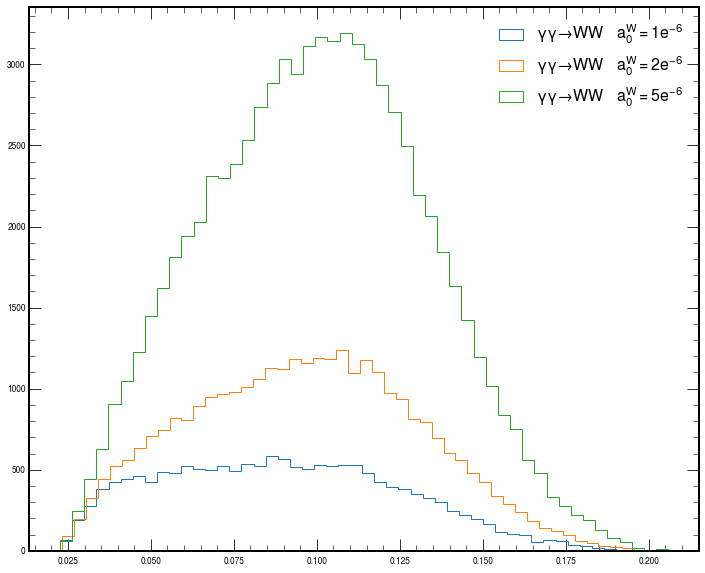

In [271]:
labels_samples = {
    "GGToWW-AQGC-A0W1e-6": r"$\gamma\gamma \to WW \quad a_0^W=1e^{-6}$",
    "GGToWW-AQGC-A0W2e-6": r"$\gamma\gamma \to WW \quad a_0^W=2e^{-6}$",
    "GGToWW-AQGC-A0W5e-6": r"$\gamma\gamma \to WW \quad a_0^W=5e^{-6}$"
}

fig = plt.figure( figsize=(12,10) )
for label_ in labels_signals: 
    plt.hist( df_signals_protons_multiRP_index[ label_ ][ 'xi' ], histtype='step', density=False, bins=50, label=labels_samples[ label_ ] )
plt.legend( loc='best', fontsize=16 )

### Ouf of acceptance protons

In [6]:
df_signals_protons_multiRP_index_2protons = {}
df_signals_protons_multiRP_index_1proton_Arm0 = {}
df_signals_protons_multiRP_index_1proton_Arm1 = {}
for label_ in labels_signals:
    df_protons_multiRP_groupby_arm_ = df_signals_protons_multiRP_index[ label_ ][ [ "arm" ] ].groupby( ["run","lumiblock","event","slice"] )
    msk_2protons_ = df_protons_multiRP_groupby_arm_[ "arm" ].transform( lambda s_: ( np.sum( s_ == 0 ) >= 1 ) & ( np.sum( s_ == 1 ) >= 1 ) )
    msk_1proton_Arm0_ = df_protons_multiRP_groupby_arm_[ "arm" ].transform( lambda s_: ( np.sum( s_ == 0 ) >= 1 ) & ( np.sum( s_ == 1 ) == 0 ) )
    msk_1proton_Arm1_ = df_protons_multiRP_groupby_arm_[ "arm" ].transform( lambda s_: ( np.sum( s_ == 0 ) == 0 ) & ( np.sum( s_ == 1 ) >= 1 ) )
    print ( msk_2protons_ )
    print ( msk_1proton_Arm0_ )
    print ( msk_1proton_Arm1_ )
    df_signals_protons_multiRP_index_2protons[ label_ ] = df_signals_protons_multiRP_index[ label_ ].loc[ msk_2protons_ ]
    df_signals_protons_multiRP_index_1proton_Arm0[ label_ ] = df_signals_protons_multiRP_index[ label_ ].loc[ msk_1proton_Arm0_ ]
    df_signals_protons_multiRP_index_1proton_Arm1[ label_ ] = df_signals_protons_multiRP_index[ label_ ].loc[ msk_1proton_Arm1_ ]

run  lumiblock  event   slice
1    2266       226549  0        False
                226551  0         True
                        0         True
     2267       226605  0        False
                226690  0        False
     2268       226734  0        False
                226716  0        False
                226773  0        False
     2270       226932  0         True
                        0         True
     2273       227227  0         True
                        0         True
     2274       227321  0        False
                227328  0        False
                227324  0        False
     2275       227457  0         True
                        0         True
     2276       227546  0         True
                        0         True
                227579  0         True
                        0         True
     2277       227611  0        False
                227610  0        False
                227661  0        False
     2278       227745  0        F

run  lumiblock  event   slice
1    6049       104807  0        False
                104823  0         True
                        0         True
                104872  0         True
                        0         True
     6050       104948  0        False
                104958  0        False
                104968  0        False
                104986  0        False
                105000  0        False
     6051       105004  0         True
                        0         True
                105009  0        False
                105026  0         True
                        0         True
                105090  0         True
                        0         True
     6052       105102  0         True
                        0         True
                105146  0        False
                105157  0        False
                105148  0        False
                105161  0        False
                105168  0         True
                        0         

In [7]:
label_ = "GGToWW-AQGC-A0W1e-6"
df_signals_protons_multiRP_index_2protons[ label_ ]

xi       thx           thy         t  \
run lumiblock event  slice                                               
1   2266      226551 0      0.047449  0.000007  2.127423e-05 -0.022129   
                     0      0.051457  0.000022  8.937085e-05 -0.342805   
    2270      226932 0      0.032306  0.000006 -7.529894e-05 -0.234367   
                     0      0.119526 -0.000012  5.454693e-06 -0.020655   
    2273      227227 0      0.056667 -0.000025 -7.198051e-05 -0.233687   
                     0      0.053138 -0.000011 -2.394333e-05 -0.030825   
    2275      227457 0      0.068920 -0.000051  2.436191e-05 -0.129756   
                     0      0.115064  0.000022  1.751353e-05 -0.042887   
    2276      227546 0      0.090561 -0.000041  7.576081e-05 -0.292089   
                     0      0.125299 -0.000021  5.446147e-05 -0.142210   
              227579 0      0.118551 -0.000022 -1.216175e-05 -0.037683   
                     0      0.169634 -0.000121 -3.192504e-05 -0.583498   
    2281      228042 0      0.105618  0.000070  1.404138e-05 -0.202386   
                     0      0.128394  0.000116  3.892736e-05 -0.572105   
    2282      228117 0      0.037401  0.000059  3.623552e-05 -0.195481   
                     0      0.058293  0.000015  7.993299e-05 -0.266754   
    2286      228503 0      0.097616 -0.000020  6.410026e-05 -0.181746   
                     0      0.106465  0.000008  1.954366e-05 -0.027956   
              228565 0      0.088063 -0.000030  8.994867e-06 -0.045153   
                     0      0.043299  0.000032  3.204928e-05 -0.084826   
    2289      228803 0      0.056202  0.000076  4.247696e-05 -0.303321   
                     0      0.158736 -0.000172  6.356418e-05 -1.226666   
    2291      229042 0      0.030846 -0.000036 -6.679903e-05 -0.237011   
                     0      0.079514 -0.000010  9.252634e-05 -0.343107   
    2296      229520 0      0.076609 -0.000050  6.654425e-06 -0.106740   
                     0      0.078162 -0.000004 -4.471247e-05 -0.084430   
    2297      229605 0      0.038556 -0.000053  3.520775e-05 -0.165811   
                     0      0.070061 -0.000017 -9.499707e-07 -0.015510   
    2298      229715 0      0.062360 -0.000034  4.791659e-05 -0.140841   
                     0      0.047336 -0.000019 -4.791983e-05 -0.109030   
...                              ...       ...           ...       ...   
    6255      125430 0      0.040117  0.000041  8.035695e-06 -0.073265   
                     0      0.092308 -0.000003  2.350409e-04 -2.127122   
    6469      146862 0      0.048089 -0.000065  1.307397e-04 -0.860273   
                     0      0.038758 -0.000020  5.310775e-05 -0.131363   
              146890 0      0.112823  0.000035  1.883756e-06 -0.059801   
                     0      0.136160 -0.000055  2.972745e-05 -0.159652   
    6470      146958 0      0.064994 -0.000029 -6.969983e-05 -0.228926   
                     0      0.048248 -0.000035  7.713395e-06 -0.054654   
              146970 0      0.110958  0.000053 -6.002958e-06 -0.117432   
                     0      0.137623 -0.000058  1.175497e-05 -0.147888   
    6534      153363 0      0.129029 -0.000070 -5.101179e-05 -0.292748   
                     0      0.134417 -0.000088 -2.296113e-05 -0.319388   
    6552      155161 0      0.068251  0.000040 -9.372151e-05 -0.413416   
                     0      0.091645 -0.000053 -2.000372e-05 -0.132771   
    6547      154620 0      0.048020  0.000086 -1.302246e-05 -0.304172   
                     0      0.093303 -0.000005 -5.288045e-05 -0.116677   
    6554      155360 0      0.098256 -0.000053 -3.820774e-06 -0.115972   
                     0      0.105238  0.000041  7.032946e-05 -0.262147   
    9014      401359 0      0.085208  0.000047  1.583940e-05 -0.100641   
                     0      0.028063  0.000062 -1.836587e-05 -0.174964   
    9015      401489 0      0.026248 -0.000056  1.129628e-05 -0.134458   
                     0      0.139251  

In [58]:
df_signals_protons_multiRP_index_1proton_Arm0[ label_ ]

xi       thx       thy         t  ismultirp  \
run lumiblock event  slice                                                      
1   2267      226690 0      0.028568  0.000061 -0.000014 -0.162398          1   
    2268      226734 0      0.122175  0.000038 -0.000003 -0.068695          1   
              226773 0      0.044415 -0.000016  0.000041 -0.081292          1   
    2277      227611 0      0.037509  0.000041  0.000004 -0.071968          1   
              227610 0      0.088627 -0.000125 -0.000004 -0.614065          1   
              227661 0      0.057884  0.000036  0.000051 -0.158605          1   
    2278      227745 0      0.084094 -0.000080 -0.000087 -0.548091          1   
    2279      227825 0      0.067304 -0.000003  0.000013 -0.011687          1   
    2280      227969 0      0.085506  0.000025  0.000011 -0.035329          1   
    2284      228313 0      0.113919 -0.000063 -0.000069 -0.342595          1   
              228336 0      0.093651 -0.000024 -0.000081 -0.283885          1   
    2292      229140 0      0.100346  0.000049 -0.000080 -0.347378          1   
              229152 0      0.051193 -0.000037  0.000006 -0.058702          1   
    2296      229519 0      0.088692 -0.000066 -0.000067 -0.346007          1   
    2297      229658 0      0.118463 -0.000053 -0.000060 -0.253881          1   
    2298      229719 0      0.082300  0.000042  0.000042 -0.143074          1   
    2299      229810 0      0.095042 -0.000026 -0.000010 -0.039098          1   
              229838 0      0.138508 -0.000087  0.000039 -0.349365          1   
    2301      230010 0      0.121829 -0.000055  0.000003 -0.127358          1   
    2303      230271 0      0.065347  0.000065 -0.000052 -0.275245          1   
    2307      230652 0      0.082578 -0.000012 -0.000039 -0.069831          1   
              230670 0      0.124798 -0.000071 -0.000061 -0.340341          1   
    2312      231107 0      0.128967 -0.000084  0.000071 -0.463002          1   
    2316      231502 0      0.123092  0.000002  0.000021 -0.031097          1   
    2317      231686 0      0.112667 -0.000036 -0.000046 -0.139537          1   
    2318      231712 0      0.069934  0.000120 -0.000012 -0.576916          1   
    2319      231885 0      0.113183  0.000060 -0.000026 -0.171440          1   
    2322      232140 0      0.050147  0.000026 -0.000023 -0.051236          1   
    2323      232271 0      0.043385 -0.000035 -0.000041 -0.118012          1   
              232270 0      0.114125 -0.000033  0.000026 -0.078459          1   
...                              ...       ...       ...       ...        ...   
    6231      123093 0      0.104345 -0.000028  0.000004 -0.040308          1   
    6234      123358 0      0.075294  0.000086 -0.000025 -0.320135          1   
    6239      123873 0      0.084326  0.000015 -0.000088 -0.315972          1   
    6249      124859 0      0.075548 -0.000015  0.000047 -0.100161          1   
    6250      124923 0      0.023661  0.000040  0.000055 -0.189078          1   
    6251      125073 0      0.114345  0.000016 -0.000017 -0.034224          1   
    6253      125254 0      0.082215  0.000115 -0.000054 -0.629589          1   
    6508      150745 0      0.041199 -0.000028 -0.000131 -0.727224          1   
    6465      146471 0      0.141470 -0.000092  0.000037 -0.376231          1   
    6534      153400 0      0.111911  0.000066 -0.000010 -0.179887          1   
              153396 0      0.036254  0.000064  0.000013 -0.172446          1   
    6547      154628 0      0.038415  0.000007 -0.000015 -0.012653          1   
    6553      155203 0      0.101202 -0.000006  0.000054 -0.123546          1   
    6488      148781 0      0.092414 -0.000134 -0.000002 -0.692924          1   
              148774 0      0.065475  0.000004  0.000003 -0.005212          1   
    9016      401525 0      0.061208  0.000031  0.000032 -0.083648          1   
    9019      401833 0      0.128527 -0.000033 -0.000013 -0.06224

In [9]:
df_signals_protons_multiRP_index_1proton_Arm1[ label_ ]

xi       thx           thy         t  \
run lumiblock event  slice                                               
1   2266      226549 0      0.049396  0.000070  5.573294e-06 -0.202391   
    2267      226605 0      0.129090  0.000042 -9.561671e-06 -0.086362   
    2268      226716 0      0.164051 -0.000072 -1.936938e-05 -0.226659   
    2274      227321 0      0.082597  0.000042 -1.787059e-05 -0.086781   
              227328 0      0.141799 -0.000062  4.827880e-06 -0.161479   
              227324 0      0.057238 -0.000019  4.545151e-05 -0.099979   
    2279      227868 0      0.062334  0.000017  1.107882e-05 -0.020236   
    2282      228121 0      0.100883 -0.000009 -4.393020e-05 -0.086406   
              228194 0      0.075288  0.000121  2.651756e-05 -0.602996   
    2283      228221 0      0.037842  0.000020  1.378915e-05 -0.025514   
    2284      228335 0      0.129740  0.000070  8.168883e-05 -0.443944   
    2294      229378 0      0.108844  0.000036  6.870371e-05 -0.237796   
    2296      229571 0      0.037841  0.000020  4.534777e-05 -0.101401   
    2299      229898 0      0.103075 -0.000015  6.839736e-05 -0.196214   
    2300      229953 0      0.060977 -0.000054  3.521776e-05 -0.168079   
    2304      230306 0      0.131520  0.000044  1.108198e-04 -0.539869   
    2305      230443 0      0.089743  0.000033 -6.768740e-05 -0.226631   
              230495 0      0.047808 -0.000033 -2.902901e-06 -0.045471   
    2308      230705 0      0.056901 -0.000049 -1.649424e-05 -0.109835   
              230740 0      0.047246  0.000003 -2.686510e-04 -2.907677   
    2310      230976 0      0.056372 -0.000012  5.037844e-05 -0.109459   
    2311      231007 0      0.123299  0.000006  4.472932e-05 -0.090658   
    2315      231473 0      0.161565 -0.000088  1.115588e-04 -0.741070   
    2316      231515 0      0.080627  0.000044 -8.201694e-05 -0.342203   
              231509 0      0.042524 -0.000029 -8.453837e-07 -0.036805   
              231559 0      0.079601  0.000026  9.164276e-05 -0.359311   
              231594 0      0.163947 -0.000135  6.941914e-06 -0.670656   
    2319      231860 0      0.097004 -0.000012 -3.483900e-06 -0.015071   
    2322      232107 0      0.134608 -0.000066  8.022647e-05 -0.414646   
    2323      232220 0      0.170070 -0.000189  2.539491e-05 -1.303906   
...                              ...       ...           ...       ...   
    6505      150469 0      0.133178  0.000012 -2.047188e-05 -0.039070   
    6486      148548 0      0.102140  0.000015  1.608771e-06 -0.018846   
    6465      146406 0      0.136299  0.000016  6.637946e-05 -0.189048   
              146497 0      0.115042  0.000071  8.152697e-05 -0.447873   
    6468      146745 0      0.132762  0.000049  4.208773e-05 -0.169881   
              146755 0      0.100209 -0.000023  1.990362e-05 -0.044611   
    6469      146827 0      0.092359  0.000018  4.540781e-05 -0.100275   
    6474      147335 0      0.088579  0.000006 -2.967883e-05 -0.043057   
              147379 0      0.062977 -0.000094  7.565684e-05 -0.577734   
    6484      148363 0      0.068993 -0.000026  7.775802e-05 -0.268943   
    6485      148442 0      0.088075 -0.000095 -2.668424e-05 -0.379770   
    6548      154790 0      0.117037  0.000092  3.655073e-05 -0.381086   
    6556      155543 0      0.134677  0.000049 -1.118579e-05 -0.112086   
              155581 0      0.095447 -0.000004 -7.263018e-05 -0.211212   
    9088      408769 0      0.106919  0.000033  6.906826e-06 -0.055162   
    9014      401316 0      0.119199  0.000168  1.001779e-04 -1.435228   
    9015      401494 0      0.066395 -0.000090 -9.678808e-05 -0.694528   
    9017      401681 0      0.075163  0.000018  2.833465e-06 -0.018004   
    9018      401784 0      0.117140  0.000047  6.548151e-05 -0.255628   
    9024      402331 0      0.107441  0.000044  4.158548e-06 -0.084092   
    9039      403821 0      0.102213  0.000027  3.204241e-05 -0.076706   
    9041      404092 0      0.075079  

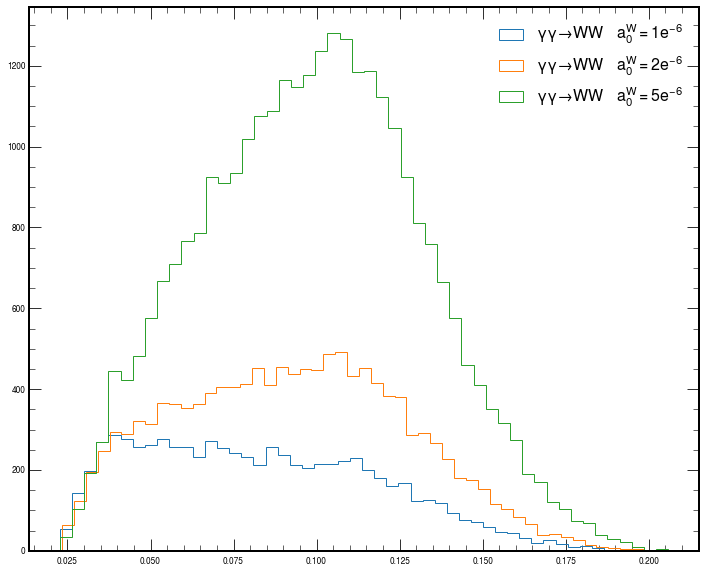

In [278]:
df_signals_protons_multiRP_index_ = df_signals_protons_multiRP_index_2protons
# df_signals_protons_multiRP_index_ = df_signals_protons_multiRP_index_1proton_Arm0
# df_signals_protons_multiRP_index_ = df_signals_protons_multiRP_index_1proton_Arm1
fig = plt.figure( figsize=(12,10) )
for label_ in labels_signals: 
    plt.hist( df_signals_protons_multiRP_index_[ label_ ][ 'xi' ], histtype='step', density=False, bins=50, label=labels_samples[ label_ ] )
plt.legend( loc='best', fontsize=16 )

### Signal with mixed protons

In [272]:
# run_tables = True

labels_signals_mix_protons = [ "GGToWW-AQGC-mix_protons-A0W1e-6", "GGToWW-AQGC-mix_protons-A0W2e-6", "GGToWW-AQGC-mix_protons-A0W5e-6" ]

fileNames_signals = {
    "GGToWW-AQGC-mix_protons-A0W1e-6": [ "output-GGToWW-AQGC-mix_protons-A0W1e-6.h5" ],
    "GGToWW-AQGC-mix_protons-A0W2e-6": [ "output-GGToWW-AQGC-mix_protons-A0W2e-6.h5" ],
    "GGToWW-AQGC-mix_protons-A0W5e-6": [ "output-GGToWW-AQGC-mix_protons-A0W5e-6.h5" ]
    }

df_counts_signals_mix_protons = {}
df_signals_protons_multiRP_mix_protons_index = {}
df_signals_protons_multiRP_mix_protons_events = {}

for label_ in labels_signals_mix_protons:
    import time
    print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
    time_s_ = time.time()

    #df_counts_signal, df_protons_multiRP_signal, df_protons_singleRP_signal, df_ppstracks_signal = 4 * [None]
    #df_protons_multiRP_signal_index, df_protons_multiRP_signal_events, df_ppstracks_signal_index = 3 * [None]

    if run_tables:
        with pd.HDFStore( "reduced-data-store-{}.h5".format( label_ ), complevel=5 ) as store_:

            df_counts_signal_, df_protons_multiRP_signal_, df_protons_singleRP_signal_, df_ppstracks_signal_ = get_data( fileNames_signals[ label_ ] )
            df_protons_multiRP_signal_index_, df_protons_multiRP_signal_events_, df_ppstracks_signal_index_ = process_data_protons_multiRP( df_protons_multiRP_signal_, df_ppstracks_signal_, apply_fiducial=True, within_aperture=True, mix_protons=True, select_2protons=False, runOnMC=True )

            store_[ "counts" ] = df_counts_signal_
            store_[ "protons_multiRP"] = df_protons_multiRP_signal_index_
            store_[ "events_multiRP" ] = df_protons_multiRP_signal_events_
    
    with pd.HDFStore( "reduced-data-store-{}.h5".format( label_ ), 'r' ) as store_:
        df_counts_signals_mix_protons[ label_ ] = store_[ "counts" ]
        df_signals_protons_multiRP_mix_protons_index[ label_ ] = store_[ "protons_multiRP" ]
        df_signals_protons_multiRP_mix_protons_events[ label_ ] = store_[ "events_multiRP" ]

    time_e_ = time.time()
    print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

2021/04/26 02:43:21
Total time elapsed: 0
2021/04/26 02:43:21
Total time elapsed: 0
2021/04/26 02:43:21
Total time elapsed: 0


In [280]:
label_signal_to_mix_protons = {
     "GGToWW-AQGC-A0W1e-6" : "GGToWW-AQGC-mix_protons-A0W1e-6",
     "GGToWW-AQGC-A0W2e-6" : "GGToWW-AQGC-mix_protons-A0W2e-6",
     "GGToWW-AQGC-A0W5e-6" : "GGToWW-AQGC-mix_protons-A0W5e-6"
}

In [282]:
label_ = "GGToWW-AQGC-A0W1e-6"
df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ]

xi           thx       thy         t  \
run lumiblock event  slice                                               
1   2268      226716 0      0.130834 -2.074428e-05 -0.000072 -0.224237   
    2273      227227 0      0.101381  2.142939e-07  0.000021 -0.026986   
    2274      227327 0      0.046442  7.412197e-05  0.000043 -0.297548   
              227324 0      0.082865  7.361628e-06  0.000021 -0.026531   
    2277      227610 0      0.096432  2.217650e-05  0.000065 -0.189026   
    2279      227868 0      0.097000 -7.361434e-05  0.000061 -0.356280   
    2281      228081 0      0.077691  2.606488e-05  0.000026 -0.059064   
    2282      228117 0      0.112774  1.075160e-05  0.000038 -0.072350   
              228194 0      0.048641  5.090548e-05 -0.000010 -0.110302   
    2283      228221 0      0.065273  7.217370e-06  0.000006 -0.007461   
              228243 0      0.069775  5.301437e-05 -0.000052 -0.220836   
    2284      228308 0      0.038047  1.158518e-04  0.000002 -0.546854   
                     0      0.092072 -1.333447e-05 -0.000001 -0.015098   
              228336 0      0.071951 -1.579587e-04  0.000059 -1.117577   
                     0      0.073436 -4.879201e-05  0.000067 -0.271841   
              228335 0      0.080832 -9.732938e-06 -0.000079 -0.253072   
    2286      228503 0      0.079755 -5.811040e-06  0.000025 -0.031093   
              228565 0      0.061203 -1.260970e-04 -0.000093 -0.979914   
    2288      228755 0      0.062711 -2.705558e-07  0.000024 -0.026048   
    2297      229651 0      0.113911 -1.238453e-04 -0.000005 -0.588068   
              229658 0      0.101123  5.449472e-05  0.000016 -0.132937   
                     0      0.142938 -1.826512e-05  0.000045 -0.105482   
    2303      230271 0      0.054790  5.034913e-06 -0.000068 -0.188220   
    2305      230467 0      0.106072 -9.048665e-05  0.000013 -0.327113   
    2308      230705 0      0.062052  2.667058e-05 -0.000082 -0.298880   
              230711 0      0.093495  7.241669e-05  0.000049 -0.302285   
              230740 0      0.064613  4.552010e-05  0.000029 -0.118930   
    2315      231473 0      0.094912  6.948594e-06  0.000036 -0.058917   
    2316      231515 0      0.151797 -3.513936e-05  0.000021 -0.083657   
              231509 0      0.066926 -6.589364e-05 -0.000062 -0.328642   
...                              ...           ...       ...       ...   
    6464      146368 0      0.104090 -2.673006e-05 -0.000058 -0.164034   
    6465      146406 0      0.079235  5.177321e-05 -0.000054 -0.223347   
              146405 0      0.069710 -8.935833e-06 -0.000060 -0.147829   
              146480 0      0.062796  5.735228e-05  0.000031 -0.171971   
    6468      146745 0      0.042195  4.898394e-05  0.000043 -0.172513   
              146755 0      0.049598  1.305429e-04 -0.000099 -1.078178   
    6469      146819 0      0.044307 -4.729909e-05 -0.000061 -0.243147   
    6470      146958 0      0.121152 -3.029905e-05  0.000057 -0.169224   
              146970 0      0.091508  5.461340e-05 -0.000066 -0.290976   
    6471      147002 0      0.048744 -4.886512e-07 -0.000111 -0.495301   
    6472      147151 0      0.062909 -3.860911e-06  0.000044 -0.080078   
    6484      148363 0      0.099232 -1.251884e-04 -0.000059 -0.737786   
                     0      0.122848 -8.996278e-05  0.000008 -0.317318   
    6493      149257 0      0.137727 -3.927171e-05  0.000170 -1.124707   
    6485      148442 0      0.120263 -2.186077e-05  0.000074 -0.234706   
    6547      154620 0      0.072464  6.622290e-05 -0.000050 -0.273155   
              154628 0      0.054683 -2.741098e-05 -0.000043 -0.106870   
    6488      148781 0      0.080598 -9.788924e-05  0.000081 -0.635797   
                     0      0.142442 -6.095683e-05  0.000108 -0.575026   
    6556      155543 0      0.065308 -6.978600e-05 -0.000122 -0.788699   
              155581 0      0.119937  2.388467e-05  0.000022 -0.053383   
    9017      401673 0      0.122491 -

In [99]:
# label_ = "GGToWW-AQGC-A0W1e-6"
# label_mix_protons_ = "GGToWW-AQGC-mix_protons-A0W1e-6"

# df_sig_2protons_ = df_signals_protons_multiRP_index_2protons[ label_ ]
# msk_arm_ = ( df_sig_2protons_.loc[ :, "arm" ] == 0 )
# df_sig_2protons_arm0_ = df_sig_2protons_.loc[ msk_arm_ ]
# index_2protons_arm0_ = df_sig_2protons_arm0_.index
# msk_arm_ = ( df_sig_2protons_.loc[ :, "arm" ] == 1 )
# df_sig_2protons_arm1_ = df_sig_2protons_.loc[ msk_arm_ ]
# index_2protons_arm1_ = df_sig_2protons_arm1_.index

# df_sig_1proton_Arm0_ = df_signals_protons_multiRP_index_1proton_Arm0[ label_ ]
# index_1proton_Arm0_ = df_sig_1proton_Arm0_.index
# df_sig_1proton_Arm1_ = df_signals_protons_multiRP_index_1proton_Arm1[ label_ ]
# index_1proton_Arm1_ = df_sig_1proton_Arm1_.index

# df_mix_ = df_signals_protons_multiRP_mix_protons_index[ label_mix_protons_ ]
# msk_arm_ = ( df_mix_.loc[ :, "arm" ] == 0 )
# df_mix_arm0_ = df_mix_.loc[ msk_arm_ ]
# index_mix_arm0_ = df_mix_arm0_.index
# msk_arm_ = ( df_mix_.loc[ :, "arm" ] == 1 )
# df_mix_arm1_ = df_mix_.loc[ msk_arm_ ]
# index_mix_arm1_ = df_mix_arm1_.index

In [168]:
# msk_sig_1proton_Arm0_mix_arm1_ = index_1proton_Arm0_.isin( index_mix_arm1_ )
# msk_mix_arm1_sig_1proton_Arm0_ = index_mix_arm1_.isin( index_1proton_Arm0_ )
# print ( np.sum( msk_sig_1proton_Arm0_mix_arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_)  )
# df_sig_1proton_Arm0_mix_arm1_ = df_sig_1proton_Arm0_.loc[ msk_sig_1proton_Arm0_mix_arm1_ ]
# df_mix_arm1_sig_1proton_Arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_1proton_Arm0_ ]
# df_1proton_Arm0_mix_Arm1_ = pd.concat( [ df_sig_1proton_Arm0_mix_arm1_, df_mix_arm1_sig_1proton_Arm0_ ] ).sort_index()

# msk_sig_1proton_Arm1_mix_arm0_ = index_1proton_Arm1_.isin( index_mix_arm0_ )
# msk_mix_arm0_sig_1proton_Arm1_ = index_mix_arm0_.isin( index_1proton_Arm1_ )
# print ( np.sum( msk_sig_1proton_Arm1_mix_arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_)  )
# df_sig_1proton_Arm1_mix_arm0_ = df_sig_1proton_Arm1_.loc[ msk_sig_1proton_Arm1_mix_arm0_ ]
# df_mix_arm0_sig_1proton_Arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_1proton_Arm1_ ]
# df_1proton_Arm1_mix_Arm0_ = pd.concat( [ df_sig_1proton_Arm1_mix_arm0_, df_mix_arm0_sig_1proton_Arm1_ ] ).sort_index()

734
734
763
763


<ipython-input-168-4114ecd58f9f>:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df_1proton_Arm0_mix_Arm1_ = pd.concat( [ df_sig_1proton_Arm0_mix_arm1_, df_mix_arm1_sig_1proton_Arm0_ ] ).sort_index()
<ipython-input-168-4114ecd58f9f>:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df_1proton_Arm1_mix_Arm0_ = pd.concat( [ df_sig_1proton_Arm1_mix_arm0_, df_mix_arm0_sig_1proton_Arm1_ ] ).sort_index()


In [230]:
# msk_mix_arm0_sig_2protons_arm0_ = index_mix_arm0_.isin( index_2protons_arm0_ )
# msk_mix_arm0_sig_2protons_arm1_ = index_mix_arm0_.isin( index_2protons_arm1_ )
# msk_mix_arm1_sig_2protons_arm0_ = index_mix_arm1_.isin( index_2protons_arm0_ )
# msk_mix_arm1_sig_2protons_arm1_ = index_mix_arm1_.isin( index_2protons_arm1_ )
# print ( np.sum( msk_mix_arm0_sig_2protons_arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_2protons_arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_2protons_arm0_ ) )
# print ( np.sum( msk_mix_arm1_sig_2protons_arm1_ ) )
# msk_mix_arm0_sig_1proton_Arm0_ = index_mix_arm0_.isin( index_1proton_Arm0_ )
# msk_mix_arm1_sig_1proton_Arm1_ = index_mix_arm1_.isin( index_1proton_Arm1_ )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_)  )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_ ) )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm1_)  )
# msk_mix_arm0_sig_2protons_ = ( msk_mix_arm0_sig_2protons_arm0_ | msk_mix_arm0_sig_2protons_arm1_ )
# msk_mix_arm1_sig_2protons_ = ( msk_mix_arm1_sig_2protons_arm0_ | msk_mix_arm1_sig_2protons_arm1_)
# msk_mix_arm0_ = ( msk_mix_arm0_sig_2protons_ | msk_mix_arm0_sig_1proton_Arm0_ | msk_mix_arm0_sig_1proton_Arm1_ )
# msk_mix_arm1_ = ( msk_mix_arm1_sig_2protons_ | msk_mix_arm1_sig_1proton_Arm0_ | msk_mix_arm1_sig_1proton_Arm1_ )
# print ( np.sum( msk_mix_arm0_ ) )
# print ( np.sum( msk_mix_arm1_ ) )
# print ( np.sum( ~msk_mix_arm0_ ) )
# print ( np.sum( ~msk_mix_arm1_ ) )
# # df_mix_arm0_sig_0protons_ = df_mix_arm0_.loc[ ~msk_mix_arm0_ ]
# # df_mix_arm1_sig_0protons_ = df_mix_arm1_.loc[ ~msk_mix_arm1_ ]

581
581
745
745
614
763
734
976
1958
2455
928
1177


In [239]:
# msk_sig_2protons_arm0_mix_arm1_ = index_2protons_arm0_.isin( index_mix_arm1_ )
# msk_sig_2protons_arm1_mix_arm1_ = index_2protons_arm1_.isin( index_mix_arm1_ )
# print ( np.sum( msk_sig_2protons_arm0_mix_arm1_ ) )
# print ( np.sum( msk_sig_2protons_arm1_mix_arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_2protons_arm0_ ) )
# msk_sig_2protons_arm1_mix_arm0_ = index_2protons_arm1_.isin( index_mix_arm0_ )
# msk_sig_2protons_arm0_mix_arm0_ = index_2protons_arm0_.isin( index_mix_arm0_ )
# print ( np.sum( msk_sig_2protons_arm1_mix_arm0_ ) )
# print ( np.sum( msk_sig_2protons_arm0_mix_arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_2protons_arm1_ ) )
# df_sig_2protons_arm0_mix_arm1_ = df_sig_2protons_arm0_.loc[ msk_sig_2protons_arm0_mix_arm1_ ]
# df_sig_2protons_arm1_mix_arm1_ = df_sig_2protons_arm1_.loc[ msk_sig_2protons_arm1_mix_arm1_ ]
# df_mix_arm1_sig_2protons_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_2protons_ ]
# # df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_.loc[ df_sig_2protons_arm0_mix_arm1_.index ].loc[ :, "eff_proton_all_weighted" ] )
# # df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ]
# df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] )
# df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ]
# df_2protons_Arm0_mix_Arm1_ = pd.concat( [ df_sig_2protons_arm0_mix_arm1_, df_mix_arm1_sig_2protons_arm0_ ] ).sort_index()
# df_sig_2protons_arm1_mix_arm0_ = df_sig_2protons_arm1_.loc[ msk_sig_2protons_arm1_mix_arm0_ ]
# df_sig_2protons_arm0_mix_arm0_ = df_sig_2protons_arm0_.loc[ msk_sig_2protons_arm0_mix_arm0_ ]
# df_mix_arm0_sig_2protons_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_2protons_arm1_ ]
# # df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_.loc[ df_sig_2protons_arm1_mix_arm0_.index ].loc[ :, "eff_proton_all_weighted" ] )
# # df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ]
# df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] )
# df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ]
# df_2protons_Arm1_mix_Arm0_ = pd.concat( [ df_sig_2protons_arm1_mix_arm0_, df_mix_arm0_sig_2protons_arm1_ ] ).sort_index()

745
745
745
581
581
581


<ipython-input-239-e714d0ae9543>:18: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df_2protons_Arm0_mix_Arm1_ = pd.concat( [ df_sig_2protons_arm0_mix_arm1_, df_mix_arm1_sig_2protons_arm0_ ] ).sort_index()
<ipython-input-239-e714d0ae9543>:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df_2protons_Arm1_mix_Arm0_ = pd.concat( [ df_sig_2protons_arm1_mix_arm0_, df_mix_arm0_sig_2protons_arm1_ ] ).sort_index()


In [189]:
# msk_mix_arm0_arm1_ = index_mix_arm0_.isin( index_mix_arm1_ )
# msk_mix_arm1_arm0_ = index_mix_arm1_.isin( index_mix_arm0_ )
# msk_sig_1proton_Arm0_mix_arm0_ = index_1proton_Arm0_.isin( index_mix_arm0_ )
# print ( np.sum( msk_mix_arm0_arm1_ ) )
# print ( np.sum( msk_mix_arm1_arm0_ ) )
# print ( np.sum( msk_sig_1proton_Arm0_mix_arm0_ ) )
# print ( np.sum( msk_sig_1proton_Arm0_mix_arm0_ & msk_sig_1proton_Arm0_mix_arm1_ ) )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm0_ & msk_mix_arm0_arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_ ) )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_ & msk_mix_arm1_arm0_ ) )
# df_sig_1proton_Arm0_mix_arm0_arm1_ = df_sig_1proton_Arm0_.loc[ msk_sig_1proton_Arm0_mix_arm0_ & msk_sig_1proton_Arm0_mix_arm1_ ]
# df_mix_arm0_sig_1proton_Arm0_mix_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_1proton_Arm0_ & msk_mix_arm0_arm1_ ]
# df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_1proton_Arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all_weighted" ] )
# df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_proton_all_weighted" ]
# df_mix_arm1_sig_1proton_Arm0_mix_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_1proton_Arm0_ & msk_mix_arm1_arm0_ ]
# df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = 1.0
# df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_all_weighted" ] = 1.0
# df_1proton_Arm0_mix_Arm0_Arm1_ = pd.concat( [ df_mix_arm0_sig_1proton_Arm0_mix_arm1_, df_mix_arm1_sig_1proton_Arm0_mix_arm0_ ] ).sort_index()

597
597
614
139
614
139
734
139


In [198]:
# msk_sig_1proton_Arm1_mix_arm1_ = index_1proton_Arm1_.isin( index_mix_arm1_ )
# print ( np.sum( msk_sig_1proton_Arm1_mix_arm1_ ) )
# print ( np.sum( msk_sig_1proton_Arm1_mix_arm1_ & msk_sig_1proton_Arm1_mix_arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_ ) )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_ & msk_mix_arm0_arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm1_ & msk_mix_arm1_arm0_ ) )
# df_sig_1proton_Arm1_mix_arm1_arm0_ = df_sig_1proton_Arm1_.loc[ msk_sig_1proton_Arm1_mix_arm1_ & msk_sig_1proton_Arm1_mix_arm0_ ]
# df_mix_arm0_sig_1proton_Arm1_mix_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_1proton_Arm1_ & msk_mix_arm0_arm1_ ]
# df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = 1.0
# df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_all_weighted" ] = 1.0
# df_mix_arm1_sig_1proton_Arm1_mix_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_1proton_Arm1_ & msk_mix_arm1_arm0_ ]
# df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_1proton_Arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all_weighted" ] )
# df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_proton_all_weighted" ]
# df_1proton_Arm1_mix_Arm1_Arm0_ = pd.concat( [ df_mix_arm0_sig_1proton_Arm1_mix_arm1_, df_mix_arm1_sig_1proton_Arm1_mix_arm0_ ] ).sort_index()

976
149
763
149
976
149


In [236]:
# print ( np.sum( msk_sig_2protons_arm0_mix_arm0_ ) )
# print ( np.sum( msk_sig_2protons_arm0_mix_arm0_ & msk_sig_2protons_arm0_mix_arm1_ ) )
# print ( np.sum( msk_sig_2protons_arm1_mix_arm1_ ) )
# print ( np.sum( msk_sig_2protons_arm1_mix_arm1_ & msk_sig_2protons_arm1_mix_arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_2protons_ ) )
# print ( np.sum( msk_mix_arm0_sig_2protons_ & msk_mix_arm0_arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_2protons_ ) )
# print ( np.sum( msk_mix_arm1_sig_2protons_ & msk_mix_arm1_arm0_ ) )
# df_sig_2protons_arm0_mix_arm0_arm1_ = df_sig_2protons_arm0_.loc[ msk_sig_2protons_arm0_mix_arm0_ & msk_sig_2protons_arm0_mix_arm1_ ]
# df_sig_2protons_arm1_mix_arm1_arm0_ = df_sig_2protons_arm1_.loc[ msk_sig_2protons_arm1_mix_arm1_ & msk_sig_2protons_arm1_mix_arm0_ ]
# df_mix_arm0_sig_2protons_mix_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_2protons_ & msk_mix_arm0_arm1_ ]
# df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all_weighted" ] )
# df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_proton_all_weighted" ]
# df_mix_arm1_sig_2protons_mix_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_2protons_ & msk_mix_arm1_arm0_ ]
# df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all_weighted" ] )
# df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_proton_all_weighted" ]
# df_2protons_mix_Arm0_Arm1 = pd.concat( [ df_mix_arm0_sig_2protons_mix_arm1_, df_mix_arm1_sig_2protons_mix_arm0_ ] ).sort_index()

581
113
745
113
581
113
745
113


In [262]:
def concatenate_sig_mix( label_, label_mix_protons_ ):
    df_sig_2protons_ = df_signals_protons_multiRP_index_2protons[ label_ ]
    msk_arm_ = ( df_sig_2protons_.loc[ :, "arm" ] == 0 )
    df_sig_2protons_arm0_ = df_sig_2protons_.loc[ msk_arm_ ]
    index_2protons_arm0_ = df_sig_2protons_arm0_.index
    msk_arm_ = ( df_sig_2protons_.loc[ :, "arm" ] == 1 )
    df_sig_2protons_arm1_ = df_sig_2protons_.loc[ msk_arm_ ]
    index_2protons_arm1_ = df_sig_2protons_arm1_.index

    df_sig_1proton_Arm0_ = df_signals_protons_multiRP_index_1proton_Arm0[ label_ ]
    index_1proton_Arm0_ = df_sig_1proton_Arm0_.index
    df_sig_1proton_Arm1_ = df_signals_protons_multiRP_index_1proton_Arm1[ label_ ]
    index_1proton_Arm1_ = df_sig_1proton_Arm1_.index

    df_mix_ = df_signals_protons_multiRP_mix_protons_index[ label_mix_protons_ ]
    msk_arm_ = ( df_mix_.loc[ :, "arm" ] == 0 )
    df_mix_arm0_ = df_mix_.loc[ msk_arm_ ]
    index_mix_arm0_ = df_mix_arm0_.index
    msk_arm_ = ( df_mix_.loc[ :, "arm" ] == 1 )
    df_mix_arm1_ = df_mix_.loc[ msk_arm_ ]
    index_mix_arm1_ = df_mix_arm1_.index
    
    # 1 proton in Arm 0, mix in Arm 1
    msk_sig_1proton_Arm0_mix_arm1_ = index_1proton_Arm0_.isin( index_mix_arm1_ )
    msk_mix_arm1_sig_1proton_Arm0_ = index_mix_arm1_.isin( index_1proton_Arm0_ )
    print ( np.sum( msk_sig_1proton_Arm0_mix_arm1_ ) )
    print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_)  )
    df_sig_1proton_Arm0_mix_arm1_ = df_sig_1proton_Arm0_.loc[ msk_sig_1proton_Arm0_mix_arm1_ ]
    df_mix_arm1_sig_1proton_Arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_1proton_Arm0_ ]
    df_mix_arm1_sig_1proton_Arm0_.loc[ :, "eff_proton_all_weighted" ] = 1.0
    df_mix_arm1_sig_1proton_Arm0_.loc[ :, "eff_all_weighted" ] = 1.0
    df_1proton_Arm0_mix_Arm1_ = pd.concat( [ df_sig_1proton_Arm0_mix_arm1_, df_mix_arm1_sig_1proton_Arm0_ ] ).sort_index()
    
    # 1 proton in Arm 1, mix in Arm 0
    msk_sig_1proton_Arm1_mix_arm0_ = index_1proton_Arm1_.isin( index_mix_arm0_ )
    msk_mix_arm0_sig_1proton_Arm1_ = index_mix_arm0_.isin( index_1proton_Arm1_ )
    print ( np.sum( msk_sig_1proton_Arm1_mix_arm0_ ) )
    print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_)  )
    df_sig_1proton_Arm1_mix_arm0_ = df_sig_1proton_Arm1_.loc[ msk_sig_1proton_Arm1_mix_arm0_ ]
    df_mix_arm0_sig_1proton_Arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_1proton_Arm1_ ]
    df_mix_arm0_sig_1proton_Arm1_.loc[ :, "eff_proton_all_weighted" ] = 1.0
    df_mix_arm0_sig_1proton_Arm1_.loc[ :, "eff_all_weighted" ] = 1.0
    df_1proton_Arm1_mix_Arm0_ = pd.concat( [ df_sig_1proton_Arm1_mix_arm0_, df_mix_arm0_sig_1proton_Arm1_ ] ).sort_index()
    
    # 0 protons
    msk_mix_arm0_sig_2protons_arm0_ = index_mix_arm0_.isin( index_2protons_arm0_ )
    msk_mix_arm0_sig_2protons_arm1_ = index_mix_arm0_.isin( index_2protons_arm1_ )
    msk_mix_arm1_sig_2protons_arm0_ = index_mix_arm1_.isin( index_2protons_arm0_ )
    msk_mix_arm1_sig_2protons_arm1_ = index_mix_arm1_.isin( index_2protons_arm1_ )
    print ( np.sum( msk_mix_arm0_sig_2protons_arm0_ ) )
    print ( np.sum( msk_mix_arm0_sig_2protons_arm1_ ) )
    print ( np.sum( msk_mix_arm1_sig_2protons_arm0_ ) )
    print ( np.sum( msk_mix_arm1_sig_2protons_arm1_ ) )
    msk_mix_arm0_sig_1proton_Arm0_ = index_mix_arm0_.isin( index_1proton_Arm0_ )
    msk_mix_arm1_sig_1proton_Arm1_ = index_mix_arm1_.isin( index_1proton_Arm1_ )
    print ( np.sum( msk_mix_arm0_sig_1proton_Arm0_ ) )
    print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_)  )
    print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_ ) )
    print ( np.sum( msk_mix_arm1_sig_1proton_Arm1_)  )
    msk_mix_arm0_sig_2protons_ = ( msk_mix_arm0_sig_2protons_arm0_ | msk_mix_arm0_sig_2protons_arm1_ )
    msk_mix_arm1_sig_2protons_ = ( msk_mix_arm1_sig_2protons_arm0_ | msk_mix_arm1_sig_2protons_arm1_)
    msk_mix_arm0_ = ( msk_mix_arm0_sig_2protons_ | msk_mix_arm0_sig_1proton_Arm0_ | msk_mix_arm0_sig_1proton_Arm1_ )
    msk_mix_arm1_ = ( msk_mix_arm1_sig_2protons_ | msk_mix_arm1_sig_1proton_Arm0_ | msk_mix_arm1_sig_1proton_Arm1_ )
    print ( np.sum( msk_mix_arm0_ ) )
    print ( np.sum( msk_mix_arm1_ ) )
    print ( np.sum( ~msk_mix_arm0_ ) )
    print ( np.sum( ~msk_mix_arm1_ ) )
    df_mix_arm0_sig_0protons_ = df_mix_arm0_.loc[ ~msk_mix_arm0_ ]
    df_mix_arm1_sig_0protons_ = df_mix_arm1_.loc[ ~msk_mix_arm1_ ]   
    df_0protons_mix_Arm0_Arm1_ = pd.concat( [ df_mix_arm0_sig_0protons_, df_mix_arm1_sig_0protons_ ] ).sort_index()
    df_0protons_mix_Arm0_Arm1_.loc[ :, "eff_proton_all_weighted" ] = 1.0
    df_0protons_mix_Arm0_Arm1_.loc[ :, "eff_all_weighted" ] = 1.0

    # 2 protons, 1 misreconstructed
    msk_sig_2protons_arm0_mix_arm1_ = index_2protons_arm0_.isin( index_mix_arm1_ )
    msk_sig_2protons_arm1_mix_arm1_ = index_2protons_arm1_.isin( index_mix_arm1_ )
    print ( np.sum( msk_sig_2protons_arm0_mix_arm1_ ) )
    print ( np.sum( msk_sig_2protons_arm1_mix_arm1_ ) )
    print ( np.sum( msk_mix_arm1_sig_2protons_arm0_ ) )
    msk_sig_2protons_arm1_mix_arm0_ = index_2protons_arm1_.isin( index_mix_arm0_ )
    msk_sig_2protons_arm0_mix_arm0_ = index_2protons_arm0_.isin( index_mix_arm0_ )
    print ( np.sum( msk_sig_2protons_arm1_mix_arm0_ ) )
    print ( np.sum( msk_sig_2protons_arm0_mix_arm0_ ) )
    print ( np.sum( msk_mix_arm0_sig_2protons_arm1_ ) )
    df_sig_2protons_arm0_mix_arm1_ = df_sig_2protons_arm0_.loc[ msk_sig_2protons_arm0_mix_arm1_ ]
    df_sig_2protons_arm1_mix_arm1_ = df_sig_2protons_arm1_.loc[ msk_sig_2protons_arm1_mix_arm1_ ]
    df_mix_arm1_sig_2protons_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_2protons_ ]
    # df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_.loc[ df_sig_2protons_arm0_mix_arm1_.index ].loc[ :, "eff_proton_all_weighted" ] )
    # df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ]
    df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] )
    df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ]
    df_2protons_Arm0_mix_Arm1_ = pd.concat( [ df_sig_2protons_arm0_mix_arm1_, df_mix_arm1_sig_2protons_arm0_ ] ).sort_index()
    df_sig_2protons_arm1_mix_arm0_ = df_sig_2protons_arm1_.loc[ msk_sig_2protons_arm1_mix_arm0_ ]
    df_sig_2protons_arm0_mix_arm0_ = df_sig_2protons_arm0_.loc[ msk_sig_2protons_arm0_mix_arm0_ ]
    df_mix_arm0_sig_2protons_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_2protons_arm1_ ]
    # df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_.loc[ df_sig_2protons_arm1_mix_arm0_.index ].loc[ :, "eff_proton_all_weighted" ] )
    # df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ]
    df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] )
    df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ]
    df_2protons_Arm1_mix_Arm0_ = pd.concat( [ df_sig_2protons_arm1_mix_arm0_, df_mix_arm0_sig_2protons_arm1_ ] ).sort_index()

    # 1 proton in Arm 0 misreconstructed, mix in Arm 1
    msk_mix_arm0_arm1_ = index_mix_arm0_.isin( index_mix_arm1_ )
    msk_mix_arm1_arm0_ = index_mix_arm1_.isin( index_mix_arm0_ )
    msk_sig_1proton_Arm0_mix_arm0_ = index_1proton_Arm0_.isin( index_mix_arm0_ )
    print ( np.sum( msk_mix_arm0_arm1_ ) )
    print ( np.sum( msk_mix_arm1_arm0_ ) )
    print ( np.sum( msk_sig_1proton_Arm0_mix_arm0_ ) )
    print ( np.sum( msk_sig_1proton_Arm0_mix_arm0_ & msk_sig_1proton_Arm0_mix_arm1_ ) )
    print ( np.sum( msk_mix_arm0_sig_1proton_Arm0_ ) )
    print ( np.sum( msk_mix_arm0_sig_1proton_Arm0_ & msk_mix_arm0_arm1_ ) )
    print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_ ) )
    print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_ & msk_mix_arm1_arm0_ ) )
    df_sig_1proton_Arm0_mix_arm0_arm1_ = df_sig_1proton_Arm0_.loc[ msk_sig_1proton_Arm0_mix_arm0_ & msk_sig_1proton_Arm0_mix_arm1_ ]
    df_mix_arm0_sig_1proton_Arm0_mix_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_1proton_Arm0_ & msk_mix_arm0_arm1_ ]
    df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_1proton_Arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all_weighted" ] )
    df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_proton_all_weighted" ]
    df_mix_arm1_sig_1proton_Arm0_mix_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_1proton_Arm0_ & msk_mix_arm1_arm0_ ]
    df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = 1.0
    df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_all_weighted" ] = 1.0
    df_1proton_Arm0_mix_Arm0_Arm1_ = pd.concat( [ df_mix_arm0_sig_1proton_Arm0_mix_arm1_, df_mix_arm1_sig_1proton_Arm0_mix_arm0_ ] ).sort_index()
    
    # 1 proton in Arm 1 misreconstructed, mix in Arm 0
    msk_sig_1proton_Arm1_mix_arm1_ = index_1proton_Arm1_.isin( index_mix_arm1_ )
    print ( np.sum( msk_sig_1proton_Arm1_mix_arm1_ ) )
    print ( np.sum( msk_sig_1proton_Arm1_mix_arm1_ & msk_sig_1proton_Arm1_mix_arm0_ ) )
    print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_ ) )
    print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_ & msk_mix_arm0_arm1_ ) )
    print ( np.sum( msk_mix_arm1_sig_1proton_Arm1_ ) )
    print ( np.sum( msk_mix_arm1_sig_1proton_Arm1_ & msk_mix_arm1_arm0_ ) )
    df_sig_1proton_Arm1_mix_arm1_arm0_ = df_sig_1proton_Arm1_.loc[ msk_sig_1proton_Arm1_mix_arm1_ & msk_sig_1proton_Arm1_mix_arm0_ ]
    df_mix_arm0_sig_1proton_Arm1_mix_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_1proton_Arm1_ & msk_mix_arm0_arm1_ ]
    df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = 1.0
    df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_all_weighted" ] = 1.0
    df_mix_arm1_sig_1proton_Arm1_mix_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_1proton_Arm1_ & msk_mix_arm1_arm0_ ]
    df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_1proton_Arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all_weighted" ] )
    df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_proton_all_weighted" ]
    df_1proton_Arm1_mix_Arm1_Arm0_ = pd.concat( [ df_mix_arm0_sig_1proton_Arm1_mix_arm1_, df_mix_arm1_sig_1proton_Arm1_mix_arm0_ ] ).sort_index()    
    
    # 2 protons, both misreconstructed
    print ( np.sum( msk_sig_2protons_arm0_mix_arm0_ ) )
    print ( np.sum( msk_sig_2protons_arm0_mix_arm0_ & msk_sig_2protons_arm0_mix_arm1_ ) )
    print ( np.sum( msk_sig_2protons_arm1_mix_arm1_ ) )
    print ( np.sum( msk_sig_2protons_arm1_mix_arm1_ & msk_sig_2protons_arm1_mix_arm0_ ) )
    print ( np.sum( msk_mix_arm0_sig_2protons_ ) )
    print ( np.sum( msk_mix_arm0_sig_2protons_ & msk_mix_arm0_arm1_ ) )
    print ( np.sum( msk_mix_arm1_sig_2protons_ ) )
    print ( np.sum( msk_mix_arm1_sig_2protons_ & msk_mix_arm1_arm0_ ) )
    df_sig_2protons_arm0_mix_arm0_arm1_ = df_sig_2protons_arm0_.loc[ msk_sig_2protons_arm0_mix_arm0_ & msk_sig_2protons_arm0_mix_arm1_ ]
    df_sig_2protons_arm1_mix_arm1_arm0_ = df_sig_2protons_arm1_.loc[ msk_sig_2protons_arm1_mix_arm1_ & msk_sig_2protons_arm1_mix_arm0_ ]
    df_mix_arm0_sig_2protons_mix_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_2protons_ & msk_mix_arm0_arm1_ ]
    df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all_weighted" ] )
    df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_proton_all_weighted" ]
    df_mix_arm1_sig_2protons_mix_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_2protons_ & msk_mix_arm1_arm0_ ]
    df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all_weighted" ] )
    df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_proton_all_weighted" ]
    df_2protons_mix_Arm0_Arm1_ = pd.concat( [ df_mix_arm0_sig_2protons_mix_arm1_, df_mix_arm1_sig_2protons_mix_arm0_ ] ).sort_index()
    
    return ( df_1proton_Arm0_mix_Arm1_,
             df_1proton_Arm1_mix_Arm0_,
             df_0protons_mix_Arm0_Arm1_,
             df_2protons_Arm0_mix_Arm1_,
             df_2protons_Arm1_mix_Arm0_,
             df_1proton_Arm0_mix_Arm0_Arm1_,
             df_1proton_Arm1_mix_Arm1_Arm0_,
             df_2protons_mix_Arm0_Arm1_
           )

In [283]:
label_ = "GGToWW-AQGC-A0W1e-6"
label_mix_protons_ = label_signal_to_mix_protons[ label_ ]
df_1proton_Arm0_mix_Arm1_, df_1proton_Arm1_mix_Arm0_, df_0protons_mix_Arm0_Arm1_, df_2protons_Arm0_mix_Arm1_, df_2protons_Arm1_mix_Arm0_, df_1proton_Arm0_mix_Arm0_Arm1_, df_1proton_Arm1_mix_Arm1_Arm0_, df_2protons_mix_Arm0_Arm1_ = concatenate_sig_mix( label_, label_mix_protons_ )

734
734


/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


763
763


<ipython-input-262-21273e17d23c>:32: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df_1proton_Arm0_mix_Arm1_ = pd.concat( [ df_sig_1proton_Arm0_mix_arm1_, df_mix_arm1_sig_1proton_Arm0_ ] ).sort_index()
<ipython-input-262-21273e17d23c>:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df_1proton_Arm1_mix_Arm0_ = pd.concat( [ df_sig_1proton_Arm1_mix_arm0_, df_mix_arm0_sig_1proton_Arm1_ ] ).sort_index()


581
581
745
745
614
763
734
976
1958
2455
928
1177
745
745
745
581
581
581


<ipython-input-262-21273e17d23c>:92: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df_2protons_Arm0_mix_Arm1_ = pd.concat( [ df_sig_2protons_arm0_mix_arm1_, df_mix_arm1_sig_2protons_arm0_ ] ).sort_index()
<ipython-input-262-21273e17d23c>:100: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df_2protons_Arm1_mix_Arm0_ = pd.concat( [ df_sig_2protons_arm1_mix_arm0_, df_mix_arm0_sig_2protons_arm1_ ] ).sort_index()


597
597
614
139
614
139
734
139
976
149
763
149
976
149
581
113
745
113
581
113
745
113


In [248]:
df_1proton_Arm0_mix_Arm1_
# df_1proton_Arm0_mix_Arm1_[ [ "eff_proton_all_weighted", "eff_all_weighted" ] ]

WLeptonicEta  WLeptonicPhi  WLeptonicPt  arm  \
run lumiblock event  slice                                                 
1   10        966    0         -0.985307     -1.474825   505.274719    0   
                     0         -0.985307     -1.474825   505.274719    1   
    19        1810   0          0.438290      0.363999   534.090881    0   
                     0          0.438290      0.363999   534.090881    1   
    21        2094   0          1.608395      1.516072   201.350113    0   
                     0          1.608395      1.516072   201.350113    1   
    43        4257   0         -0.466070     -2.336476   915.153137    0   
                     0         -0.466070     -2.336476   915.153137    1   
    56        5597   0          1.112478      0.258315   215.803085    0   
                     0          1.112478      0.258315   215.803085    1   
    59        5826   0          0.502987     -0.047176   326.634460    0   
                     0          0.502987     -0.047176   326.634460    1   
    86        8575   0         -0.421112     -1.043117   361.263428    0   
                     0         -0.421112     -1.043117   361.263428    1   
    132       13188  0          0.175337      2.816428   412.188843    0   
                     0          0.175337      2.816428   412.188843    1   
    138       13776  0          1.086792     -0.850862   218.845764    0   
                     0          1.086792     -0.850862   218.845764    1   
    145       14421  0         -0.045122     -2.898558   206.346832    0   
                     0         -0.045122     -2.898558   206.346832    1   
    187       18621  0         -0.167193      0.882904   216.399063    0   
                     0         -0.167193      0.882904   216.399063    1   
              18665  0          0.025103     -0.166182   216.795044    0   
                     0          0.025103     -0.166182   216.795044    1   
    197       19614  0         -0.275810      2.457591   257.138916    0   
                     0         -0.275810      2.457591   257.138916    1   
    214       21321  0          0.633040      1.008118   306.320129    0   
                     0          0.633040      1.008118   306.320129    1   
    226       22505  0          0.046736     -1.023748   247.173950    0   
                     0          0.046736     -1.023748   247.173950    1   
...                                  ...           ...          ...  ...   
    9805      480467 0          0.346861      0.354181   241.388107    0   
                     0          0.346861      0.354181   241.388107    1   
    9830      482941 0          0.922501      2.395409   440.443481    0   
                     0          0.922501      2.395409   440.443481    1   
    9845      484483 0          1.294656      3.122839   244.923920    0   
                     0          1.294656      3.122839   244.923920    1   
    9848      484760 0          0.453610     -0.314322   227.264923    0   
                     0          0.453610     -0.314322   227.264923    1   
    9849      484842 0          0.322589     -3.024757   210.050858    0   
                     0          0.322589     -3.024757   210.050858    1   
    9909      490804 0         -0.258378     -0.418287   206.314041    0   
                     0         -0.258378     -0.418287   206.314041    1   
    9925      492416 0          1.180644     -1.853343   319.474487    0   
                     0          1.180644     -1.853343   319.474487    1   
    9930      492948 0          0.304270      2.077964   652.936768    0   
                     0          0.304270      2.077964   652.936768    1   
    9940      493913 0         -0.161883      1.050141   500.338318    0   
                     0         -0.161883      1.050141   500.338318    1   
    9952      495192 0          1.177193     -3.047021   242.045761    0   
                     0          1.177193     -3.047021   242.045761    1   


In [249]:
df_1proton_Arm1_mix_Arm0_
# df_1proton_Arm1_mix_Arm0_[ [ "eff_proton_all_weighted", "eff_all_weighted" ] ]

WLeptonicEta  WLeptonicPhi  WLeptonicPt  arm  \
run lumiblock event  slice                                                 
1   4         330    0          0.349475      1.487545   756.894714    1   
                     0          0.349475      1.487545   756.894714    0   
    17        1668   0         -0.089589      0.610390   764.989807    1   
                     0         -0.089589      0.610390   764.989807    0   
    78        7721   0          0.242673      2.702093   607.293640    1   
                     0          0.242673      2.702093   607.293640    0   
    93        9253   0         -0.106473      3.129768   611.415100    1   
                     0         -0.106473      3.129768   611.415100    0   
    103       10231  0         -1.245734     -1.762597   210.641937    1   
                     0         -1.245734     -1.762597   210.641937    0   
    108       10724  0         -0.077513      1.100980   909.481934    1   
                     0         -0.077513      1.100980   909.481934    0   
              10768  0          0.900828     -2.330522   845.616760    1   
                     0          0.900828     -2.330522   845.616760    0   
    113       11246  0          0.542230     -0.286736   833.244324    1   
                     0          0.542230     -0.286736   833.244324    0   
    130       12908  0          0.644195      1.156114   729.573792    1   
                     0          0.644195      1.156114   729.573792    0   
    131       13034  0         -0.180480      2.174621   720.046448    1   
                     0         -0.180480      2.174621   720.046448    0   
    157       15652  0          0.237115     -2.711223   919.796753    1   
                     0          0.237115     -2.711223   919.796753    0   
    173       17260  0         -0.275767     -0.948066   381.911041    1   
                     0         -0.275767     -0.948066   381.911041    0   
              17283  0          0.051733      0.572649   535.064636    1   
                     0          0.051733      0.572649   535.064636    0   
    180       17914  0         -1.410835      2.681355   264.828094    1   
                     0         -1.410835      2.681355   264.828094    0   
    184       18330  0          0.412383     -0.955425   661.679504    1   
                     0          0.412383     -0.955425   661.679504    0   
...                                  ...           ...          ...  ...   
    9869      486829 0         -0.062360     -0.533666   962.126587    1   
                     0         -0.062360     -0.533666   962.126587    0   
    9871      487092 0          0.244102      1.378969  1062.724854    1   
                     0          0.244102      1.378969  1062.724854    0   
    9891      489093 0         -0.148065      0.196879   874.195251    1   
                     0         -0.148065      0.196879   874.195251    0   
    9896      489594 0          0.035285     -1.744613   795.222412    1   
                     0          0.035285     -1.744613   795.222412    0   
    9898      489741 0         -0.174708      0.367195   878.132385    1   
                     0         -0.174708      0.367195   878.132385    0   
    9900      489948 0         -0.465792     -2.346549   511.430115    1   
                     0         -0.465792     -2.346549   511.430115    0   
    9937      493601 0          0.286619     -1.726022   946.161560    1   
                     0          0.286619     -1.726022   946.161560    0   
    9941      494085 0          1.147916      0.008424   577.326111    1   
                     0          1.147916      0.008424   577.326111    0   
    9943      494206 0         -0.487564      1.527855   753.348450    1   
                     0         -0.487564      1.527855   753.348450    0   
    9944      494399 0         -0.424845     -0.648485   829.237549    1   
                     0         -0.424845     -0.648485   829.237549    0   


In [260]:
df_0protons_mix_Arm0_Arm1_
# df_0protons_mix_Arm0_Arm1_[ [ "eff_proton_all_weighted", "eff_all_weighted" ] ]

xi           thx           thy         t  \
run lumiblock event  slice                                                   
1   1         5      0      0.074012 -6.449015e-06 -4.156355e-05 -0.074404   
    2         146    0      0.140001 -2.009194e-06  2.061265e-05 -0.035645   
    6         572    0      0.137623 -2.922394e-05 -4.767118e-05 -0.133225   
    10        939    0      0.052833 -1.029146e-04 -9.806968e-05 -0.811178   
    13        1257   0      0.062042 -7.305356e-05 -1.964278e-05 -0.230355   
                     0      0.059261  1.328856e-05 -4.189067e-05 -0.080040   
    17        1639   0      0.088078 -2.153347e-05  4.950805e-05 -0.119771   
    18        1762   0      0.091406  8.597277e-05 -3.008373e-05 -0.326510   
    24        2335   0      0.055997 -4.923185e-05 -8.027254e-05 -0.356508   
    32        3114   0      0.056471  9.706317e-05  4.364992e-05 -0.454405   
    40        3931   0      0.121830  1.081176e-05 -7.407013e-06 -0.021251   
    43        4235   0      0.054692  1.063798e-04 -8.076530e-05 -0.715089   
              4249   0      0.071429  1.723842e-04 -1.036452e-04 -1.591725   
    45        4412   0      0.042680 -6.525176e-05 -1.329904e-04 -0.889030   
    50        4903   0      0.107248  2.868243e-05  1.131778e-05 -0.047196   
    55        5413   0      0.149670 -3.368074e-05  1.060361e-04 -0.467754   
    60        5965   0      0.114546 -4.421188e-05 -3.403024e-05 -0.129466   
    65        6408   0      0.104581  1.802205e-05 -9.675015e-06 -0.026579   
              6452   0      0.066960 -3.551285e-05 -1.131148e-04 -0.558220   
    69        6840   0      0.082921  1.037574e-04  4.976045e-05 -0.519526   
    82        8106   0      0.089596 -3.561780e-05 -1.034956e-04 -0.468453   
    97        9684   0      0.056265  1.865385e-05 -1.225309e-04 -0.615320   
                     0      0.034866  9.742305e-05  1.316476e-04 -1.094572   
    105       10461  0      0.064041  2.311298e-04  1.248843e-05 -2.121997   
                     0      0.113800 -3.680636e-05  3.339424e-05 -0.105320   
    106       10543  0      0.125652  1.840938e-06  3.215514e-06 -0.016404   
    111       11065  0      0.037194 -6.005824e-06  1.181799e-04 -0.570728   
    114       11390  0      0.077759 -1.425624e-04 -1.269892e-05 -0.803778   
    121       12081  0      0.146630 -1.878953e-05  2.745955e-05 -0.062086   
    133       13293  0      0.112459 -3.979023e-05 -1.083642e-05 -0.076305   
...                              ...           ...           ...       ...   
    9863      486263 0      0.065439 -1.399901e-04 -2.655715e-07 -0.777675   
    9873      487260 0      0.082052 -1.224554e-05 -6.393245e-05 -0.170765   
    9876      487507 0      0.068383  1.209139e-04 -7.307906e-05 -0.789866   
              487539 0      0.084403  2.464881e-05 -1.936272e-05 -0.044849   
    9882      488157 0      0.052145  5.155170e-05 -2.921157e-05 -0.143091   
    9887      488613 0      0.080787 -2.171330e-05 -9.374269e-05 -0.365758   
              488666 0      0.097725  4.218608e-05 -1.385790e-05 -0.084461   
                     0      0.145300 -5.908771e-05  2.669575e-05 -0.173515   
    9890      488985 0      0.127004 -2.123822e-05 -7.171605e-06 -0.034795   
    9904      490313 0      0.068842  1.812596e-05 -4.803676e-05 -0.108162   
    9910      490901 0      0.083241  4.429928e-07 -1.209937e-05 -0.012330   
    9914      491308 0      0.087271 -4.776524e-05  1.594623e-06 -0.095401   
              491369 0      0.073837  6.375632e-05 -8.479487e-07 -0.164243   
    9922      492150 0      0.138517 -3.438452e-06  2.658622e-05 -0.045758   
    9926      492529 0      0.104811  7.538330e-05  5.705195e-05 -0.348754   
    9943      494210 0      0.128150  7.082549e-06 -1.293506e-06 -0.018492   
    9950      494904 0      0.067490 -6.158272e-05  2.199292e-05 -0.172738   
    9956      495504 0      0.066439 -2.158975e-05 -7.580737e-05 -0.249165   
    9958      495749 0      0.139395  1.495529e-05  4.65

In [251]:
df_2protons_Arm0_mix_Arm1_
# df_2protons_Arm0_mix_Arm1_[ [ "eff_proton_all_weighted", "eff_all_weighted" ] ]

WLeptonicEta  WLeptonicPhi  WLeptonicPt  arm  \
run lumiblock event  slice                                                 
1   36        3502   0          1.120792      1.741649   175.326111    0   
                     0          1.120792      1.741649   175.326111    1   
    54        5302   0         -0.158887     -0.117209   199.539337    0   
                     0         -0.158887     -0.117209   199.539337    1   
    72        7145   0         -0.307204     -1.169140   664.679382    0   
                     0         -0.307204     -1.169140   664.679382    1   
    86        8531   0          0.831584     -1.377475   328.600311    0   
                     0          0.831584     -1.377475   328.600311    1   
    105       10427  0          1.022883     -2.167952   424.494202    0   
                     0          1.022883     -2.167952   424.494202    1   
    109       10818  0          1.804047      1.656871   197.106827    0   
                     0          1.804047      1.656871   197.106827    1   
    184       18365  0          0.224709      0.665772   625.205078    0   
                     0          0.224709      0.665772   625.205078    1   
    198       19795  0          0.139520      0.975307   269.049683    0   
                     0          0.139520      0.975307   269.049683    1   
    213       21265  0         -0.835570      0.332135   247.000763    0   
                     0         -0.835570      0.332135   247.000763    1   
    216       21557  0         -1.738028      1.650949   217.432571    0   
                     0         -1.738028      1.650949   217.432571    1   
    223       22299  0         -1.105012      1.880367   213.794281    0   
                     0         -1.105012      1.880367   213.794281    1   
    225       22407  0         -0.064325      1.314248   204.904343    0   
                     0         -0.064325      1.314248   204.904343    1   
    235       23417  0         -0.739540      2.089319   228.088593    0   
                     0         -0.739540      2.089319   228.088593    1   
    237       23630  0         -1.425017     -0.202990   290.508942    0   
                     0         -1.425017     -0.202990   290.508942    1   
    246       24522  0         -1.487566      0.484901   252.093475    0   
                     0         -1.487566      0.484901   252.093475    1   
...                                  ...           ...          ...  ...   
    9816      481587 0         -0.185583      1.411653   670.198853    0   
                     0         -0.185583      1.411653   670.198853    1   
    9823      482226 0          0.086914     -1.694634   433.524536    0   
                     0          0.086914     -1.694634   433.524536    1   
    9842      484136 0         -1.027824      0.603648   183.772507    0   
                     0         -1.027824      0.603648   183.772507    1   
    9852      485127 0         -0.603989      3.062534   623.401123    0   
                     0         -0.603989      3.062534   623.401123    1   
              485170 0          0.240545      0.517233   579.238037    0   
                     0          0.240545      0.517233   579.238037    1   
    9855      485415 0          0.377569      1.544282   260.638489    0   
                     0          0.377569      1.544282   260.638489    1   
    9876      487564 0         -0.068832     -1.757034   550.861084    0   
                     0         -0.068832     -1.757034   550.861084    1   
    9877      487615 0          1.370586     -1.686568   202.486633    0   
                     0          1.370586     -1.686568   202.486633    1   
    9878      487796 0         -0.340699      2.681939   669.923584    0   
                     0         -0.340699      2.681939   669.923584    1   
    9887      488636 0          0.700188      0.289434   280.214020    0   
                     0          0.700188      0.289434   280.214020    1   


In [252]:
df_2protons_Arm1_mix_Arm0_
# df_2protons_Arm1_mix_Arm0_[ [ "eff_proton_all_weighted", "eff_all_weighted" ] ]

WLeptonicEta  WLeptonicPhi  WLeptonicPt  arm  \
run lumiblock event  slice                                                 
1   29        2899   0         -0.446709      0.295419   419.406342    1   
                     0         -0.446709      0.295419   419.406342    0   
    48        4763   0         -0.001335     -1.128798   675.310547    1   
                     0         -0.001335     -1.128798   675.310547    0   
    50        4970   0          0.122426     -2.050302   261.826477    1   
                     0          0.122426     -2.050302   261.826477    0   
    70        6984   0          1.753025     -0.834753   210.441666    1   
                     0          1.753025     -0.834753   210.441666    0   
    96        9567   0          1.286780     -2.073812   272.154877    1   
                     0          1.286780     -2.073812   272.154877    0   
    153       15274  0         -0.981721     -0.340122   236.656677    1   
                     0         -0.981721     -0.340122   236.656677    0   
    160       15969  0          0.133743      0.685610   240.957794    1   
                     0          0.133743      0.685610   240.957794    0   
    171       17026  0          0.676764      1.213323   314.136993    1   
                     0          0.676764      1.213323   314.136993    0   
    185       18499  0         -0.258921     -1.577320   818.603577    1   
                     0         -0.258921     -1.577320   818.603577    0   
    200       19968  0         -0.870715     -0.831564   634.932739    1   
                     0         -0.870715     -0.831564   634.932739    0   
    209       20845  0         -0.482134     -0.769640   292.601257    1   
                     0         -0.482134     -0.769640   292.601257    0   
    245       24476  0          0.523671      2.297891   659.433167    1   
                     0          0.523671      2.297891   659.433167    0   
    246       24522  0         -1.487566      0.484901   252.093475    1   
                     0         -1.487566      0.484901   252.093475    0   
    251       25015  0         -0.754527     -2.243932   236.487778    1   
                     0         -0.754527     -2.243932   236.487778    0   
    283       28246  0         -0.607018     -1.993784   219.079071    1   
                     0         -0.607018     -1.993784   219.079071    0   
...                                  ...           ...          ...  ...   
    9740      473972 0          0.746689     -1.260287   288.219727    1   
                     0          0.746689     -1.260287   288.219727    0   
    9741      474033 0          0.017408      3.057448   652.893372    1   
                     0          0.017408      3.057448   652.893372    0   
    9758      475763 0         -0.033029     -0.531249   288.561249    1   
                     0         -0.033029     -0.531249   288.561249    0   
    9811      481086 0          0.134888     -0.049470   694.336853    1   
                     0          0.134888     -0.049470   694.336853    0   
    9864      486374 0         -1.795339      2.836797   223.374893    1   
                     0         -1.795339      2.836797   223.374893    0   
    9867      486623 0         -1.009721      2.258162   224.092102    1   
                     0         -1.009721      2.258162   224.092102    0   
    9872      487197 0         -1.053077     -2.457541   209.005447    1   
                     0         -1.053077     -2.457541   209.005447    0   
    9877      487615 0          1.370586     -1.686568   202.486633    1   
                     0          1.370586     -1.686568   202.486633    0   
    9887      488668 0          0.028971     -0.875126   553.069702    1   
                     0          0.028971     -0.875126   553.069702    0   
    9928      492715 0         -0.156792      0.070658   694.579529    1   
                     0         -0.156792      0.070658   694.579529    0   


In [253]:
df_1proton_Arm0_mix_Arm0_Arm1_

xi       thx           thy         t  \
run lumiblock event  slice                                               
1   43        4257   0      0.062994  0.000052 -5.954159e-05 -0.253136   
                     0      0.106416 -0.000019  1.906305e-05 -0.038254   
    86        8575   0      0.048011  0.000059  3.388276e-06 -0.144387   
                     0      0.074650 -0.000034  1.185711e-05 -0.055151   
    187       18621  0      0.043373 -0.000004 -7.968039e-05 -0.258913   
                     0      0.120208 -0.000081  8.873490e-05 -0.549087   
              18665  0      0.106833  0.000015 -1.087572e-05 -0.024390   
                     0      0.088640 -0.000016  3.127089e-05 -0.054589   
    197       19614  0      0.051056  0.000032 -3.901574e-05 -0.104088   
                     0      0.074779  0.000018 -3.669861e-05 -0.070613   
    335       33421  0      0.065572  0.000010 -4.204339e-05 -0.078119   
                     0      0.062503 -0.000081 -6.088275e-05 -0.412234   
    376       37578  0      0.094354 -0.000025 -5.946095e-05 -0.166936   
                     0      0.071902 -0.000033 -7.452670e-05 -0.266136   
    454       45390  0      0.087331 -0.000039  2.091643e-05 -0.081784   
                     0      0.090559 -0.000003  4.232748e-05 -0.077036   
    464       46345  0      0.027520  0.000028 -1.371506e-04 -0.806327   
                     0      0.102907  0.000026 -1.545346e-05 -0.045384   
    473       47285  0      0.074882  0.000075 -6.790713e-05 -0.407566   
                     0      0.085078 -0.000016  1.127591e-04 -0.507808   
    633       63247  0      0.056773 -0.000111  1.099344e-04 -0.977181   
                     0      0.082808  0.000004 -9.915215e-05 -0.388187   
    705       70452  0      0.032087 -0.000090  5.661668e-05 -0.459984   
                     0      0.040716 -0.000080 -2.906232e-05 -0.298221   
    769       76894  0      0.062619  0.000102 -8.156877e-05 -0.680122   
                     0      0.087554 -0.000006  1.940761e-05 -0.023085   
    838       83761  0      0.102017  0.000018  5.592055e-05 -0.141663   
                     0      0.027682  0.000219 -1.811658e-04 -3.317807   
    964       96351  0      0.059543  0.000013 -1.838559e-05 -0.023795   
                     0      0.070010  0.000014 -3.970344e-05 -0.073972   
...                              ...       ...           ...       ...   
    9292      429195 0      0.053597 -0.000040 -1.167087e-04 -0.610641   
                     0      0.042066 -0.000027  5.287962e-05 -0.144535   
    9304      430355 0      0.083002  0.000075 -4.786429e-06 -0.223564   
                     0      0.114017 -0.000052  4.385724e-06 -0.115939   
              430395 0      0.077642 -0.000003  1.317843e-08 -0.006081   
                     0      0.095602 -0.000027 -5.410560e-05 -0.149003   
    9434      443369 0      0.051974 -0.000055 -6.270441e-05 -0.281494   
                     0      0.067557  0.000057 -2.108301e-05 -0.149781   
    9438      443745 0      0.048764 -0.000015 -3.013146e-05 -0.047679   
                     0      0.106108 -0.000030 -3.492411e-05 -0.090641   
    9493      449207 0      0.089097  0.000020  1.417439e-04 -0.796735   
                     0      0.085869 -0.000047 -4.563751e-07 -0.092465   
    9501      450076 0      0.050067 -0.000005 -5.737519e-05 -0.135479   
                     0      0.066607  0.000007  3.122150e-05 -0.044787   
    9540      453923 0      0.069102 -0.000042  7.095148e-06 -0.076294   
                     0      0.103616  0.000018 -6.095613e-05 -0.163927   
    9590      458995 0      0.045941 -0.000055 -1.276278e-04 -0.780299   
                     0      0.077683  0.000029 -3.048866e-05 -0.075070   
    9617      461658 0      0.045929 -0.000064 -3.958210e-05 -0.229790   
                     0      0.100239  0.000015  2.633547e-05 -0.044262   
    9623      462285 0      0.054491  0.000086 -5.288173e-05 -0.409313   
                     0      0.073790  

In [254]:
df_1proton_Arm1_mix_Arm1_Arm0_

xi           thx       thy         t  \
run lumiblock event  slice                                               
1   173       17283  0      0.084511 -3.285768e-05 -0.000092 -0.377566   
                     0      0.121276  4.860070e-05 -0.000028 -0.132367   
    221       22053  0      0.045295 -8.694456e-06 -0.000037 -0.060539   
                     0      0.146437 -4.039773e-05  0.000057 -0.199526   
    282       28166  0      0.035429  5.748094e-05 -0.000142 -0.961381   
                     0      0.118762 -5.816713e-05  0.000017 -0.150884   
    347       34628  0      0.099050  6.534123e-05  0.000014 -0.179138   
                     0      0.131519  9.237227e-06  0.000059 -0.147854   
    426       42523  0      0.080527  2.350185e-05 -0.000010 -0.031204   
                     0      0.083391  2.518369e-05 -0.000018 -0.043421   
    475       47429  0      0.092662 -4.803526e-05  0.000056 -0.218136   
                     0      0.080383  4.715560e-05  0.000059 -0.229229   
    516       51552  0      0.062517 -2.972345e-05  0.000026 -0.066403   
                     0      0.041907  5.163632e-05 -0.000060 -0.253180   
    699       69858  0      0.104918  6.727489e-05 -0.000018 -0.194495   
                     0      0.063562  5.259628e-05  0.000050 -0.212129   
    826       82568  0      0.124977 -1.170467e-04  0.000162 -1.494835   
                     0      0.044088 -2.861290e-05 -0.000093 -0.383667   
    827       82640  0      0.084531 -4.733483e-05  0.000080 -0.341322   
                     0      0.038373  6.664750e-05 -0.000130 -0.867941   
    895       89414  0      0.125714 -8.318881e-05 -0.000010 -0.275210   
                     0      0.137306 -1.791444e-06  0.000116 -0.512600   
    897       89649  0      0.070869 -6.090711e-05 -0.000065 -0.313632   
                     0      0.087272  1.286763e-04 -0.000104 -1.064434   
    908       90720  0      0.086375 -3.125361e-05 -0.000054 -0.156819   
                     0      0.119490 -2.364345e-05 -0.000063 -0.180996   
    910       90902  0      0.044016  4.782815e-05 -0.000113 -0.608834   
                     0      0.094648 -3.674023e-05  0.000145 -0.869014   
    1000      99947  0      0.092740  2.811290e-05  0.000131 -0.693839   
                     0      0.047421  2.921583e-05  0.000013 -0.042790   
...                              ...           ...       ...       ...   
    9097      409604 0      0.105217  5.263108e-05  0.000062 -0.259402   
                     0      0.129561 -4.776225e-05 -0.000039 -0.155716   
    9172      417158 0      0.052136 -1.386116e-04 -0.000099 -1.165591   
                     0      0.104488 -3.544518e-06  0.000130 -0.646184   
    9238      423715 0      0.040010  2.465221e-05 -0.000063 -0.185278   
                     0      0.110094 -9.198532e-05  0.000004 -0.330752   
    9303      430257 0      0.134378 -9.944405e-05  0.000008 -0.382025   
                     0      0.068208  2.722069e-05  0.000076 -0.260258   
    9312      431157 0      0.060315  7.549714e-05 -0.000059 -0.369772   
                     0      0.065057 -2.552606e-07  0.000009 -0.007001   
    9329      432826 0      0.105508  4.322222e-05 -0.000052 -0.183460   
                     0      0.055278  6.838898e-05 -0.000010 -0.193248   
    9357      435697 0      0.044259 -3.476031e-05 -0.000130 -0.734508   
                     0      0.096218 -3.178785e-05 -0.000053 -0.152888   
    9379      437801 0      0.127388 -1.038683e-04  0.000088 -0.696635   
                     0      0.091588 -1.441077e-05 -0.000007 -0.017807   
    9413      441292 0      0.028840  2.926478e-05 -0.000112 -0.548764   
                     0      0.041661 -4.736531e-05 -0.000022 -0.111675   
    9595      459476 0      0.038530 -2.635217e-05 -0.000004 -0.030132   
                     0      0.076897 -3.103642e-06 -0.000070 -0.194615   
    9627      462632 0      0.073799  3.509819e-06 -0.000042 -0.073516   
                     0      0.126313 -

In [264]:
df_2protons_mix_Arm0_Arm1_

xi           thx           thy         t  \
run lumiblock event  slice                                                   
1   246       24522  0      0.092791 -2.298737e-06 -1.705000e-05 -0.019698   
                     0      0.056943 -8.976027e-05  5.176039e-05 -0.430722   
    350       34969  0      0.096017  1.257628e-04  3.238095e-05 -0.652942   
                     0      0.031787  2.163680e-04 -1.704927e-04 -3.104295   
    453       45291  0      0.084585 -1.153856e-04  2.267166e-05 -0.541579   
                     0      0.067959  3.177576e-05 -6.350772e-05 -0.202905   
    638       63744  0      0.073401  2.498660e-05  2.231351e-05 -0.049042   
                     0      0.110796 -9.536016e-05  1.707086e-05 -0.364650   
    741       74074  0      0.112681 -2.647307e-05  6.487140e-05 -0.196591   
                     0      0.110798  1.928306e-05  1.065657e-05 -0.030385   
    924       92306  0      0.057489 -1.560179e-05 -1.382257e-04 -0.773426   
                     0      0.077019 -5.645179e-06 -6.097226e-05 -0.151837   
    1115      111408 0      0.081680 -1.127607e-05 -1.042983e-04 -0.433285   
                     0      0.091124  3.434673e-05  1.933447e-06 -0.053476   
    1127      112689 0      0.035788  5.379470e-05 -2.414758e-04 -2.493901   
                     0      0.088085  9.074283e-05  1.159792e-04 -0.842791   
    1133      113275 0      0.084691  5.342734e-05  3.282211e-05 -0.158910   
                     0      0.094050 -2.750950e-05 -2.255179e-05 -0.057017   
    1172      117167 0      0.046754  1.674358e-05 -5.283243e-05 -0.125696   
                     0      0.112919  8.598747e-05 -6.521807e-05 -0.449076   
    1198      119729 0      0.120311 -5.318564e-05 -1.076591e-05 -0.123897   
                     0      0.108577  1.576168e-04  6.018894e-05 -1.083434   
    1216      121548 0      0.033715 -3.027589e-05  2.248302e-05 -0.059080   
                     0      0.059346  1.419763e-05  5.822592e-05 -0.146010   
    1334      133384 0      0.037645  5.133259e-06  3.030846e-05 -0.039710   
                     0      0.041531  1.319840e-04 -2.895108e-05 -0.740790   
    1433      143244 0      0.091567 -5.054812e-05 -9.035630e-05 -0.419447   
                     0      0.118194 -7.135155e-05 -1.523818e-05 -0.212223   
    1557      155630 0      0.062121 -7.942229e-05 -1.010182e-04 -0.657803   
                     0      0.048439  3.695755e-05 -5.846631e-05 -0.194471   
...                              ...           ...           ...       ...   
    8831      383073 0      0.085865  6.735045e-05  2.656770e-06 -0.182530   
                     0      0.077673  2.730669e-05  1.003861e-05 -0.038736   
    8861      386003 0      0.079946 -2.163622e-05  1.854140e-05 -0.037671   
                     0      0.100324  7.183869e-05 -7.906526e-05 -0.443563   
    8939      393888 0      0.100279  1.019633e-04  3.145176e-05 -0.442541   
                     0      0.139377  1.717185e-05 -2.492808e-05 -0.053180   
    9036      403535 0      0.059140 -9.212104e-05 -1.073930e-04 -0.798910   
                     0      0.094805  3.564757e-05 -3.661373e-05 -0.108589   
    9117      411689 0      0.105223 -6.834605e-06 -4.796467e-07 -0.012668   
                     0      0.080803 -3.868241e-05 -2.336109e-05 -0.085540   
    9234      423328 0      0.105066 -2.231806e-05 -2.241730e-06 -0.029879   
                     0      0.090607 -1.438111e-06 -1.523382e-05 -0.016942   
    9289      428827 0      0.100463  9.524448e-05  6.843294e-05 -0.532498   
                     0      0.060290 -6.039219e-05 -6.434144e-05 -0.312496   
    9522      452172 0      0.049608 -7.051174e-05 -5.955548e-05 -0.344271   
                     0      0.087775  7.051075e-05  6.960332e-05 -0.385694   
    9601      460019 0      0.086316  8.234890e-05  3.475181e-05 -0.315504   
                     0      0.047265  9.798849e-07 -1.072717e-04 -0.465189   
    9683      468274 0      0.102859 -5.040162e-05 -1.55

In [303]:
labels_out_acceptance_misreconstructed_ = ( "1proton_Arm0_mix_Arm1", "1proton_Arm1_mix_Arm0", "0protons_mix_Arm0_Arm1",
                                            "2protons_Arm0_mix_Arm1", "2protons_Arm1_mix_Arm0",
                                            "1proton_Arm0_mix_Arm0_Arm1", "1proton_Arm1_mix_Arm1_Arm0", "2protons_mix_Arm0_Arm1" )

df_signals_protons_multiRP_out_acceptance_misreconstructed = {}

for label_ in labels_signals:
    label_mix_protons_ = label_signal_to_mix_protons[ label_ ]
    df_signals_protons_multiRP_out_acceptance_misreconstructed__ = concatenate_sig_mix( label_, label_mix_protons_ )
    df_signals_protons_multiRP_out_acceptance_misreconstructed[ label_ ] = {}
    for idx_, df__ in enumerate( df_signals_protons_multiRP_out_acceptance_misreconstructed__ ):
        df_signals_protons_multiRP_out_acceptance_misreconstructed[ label_ ][ labels_out_acceptance_misreconstructed_[ idx_ ] ] = df__

734
734


<ipython-input-262-21273e17d23c>:32: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df_1proton_Arm0_mix_Arm1_ = pd.concat( [ df_sig_1proton_Arm0_mix_arm1_, df_mix_arm1_sig_1proton_Arm0_ ] ).sort_index()


763
763


<ipython-input-262-21273e17d23c>:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df_1proton_Arm1_mix_Arm0_ = pd.concat( [ df_sig_1proton_Arm1_mix_arm0_, df_mix_arm0_sig_1proton_Arm1_ ] ).sort_index()


581
581
745
745
614
763
734
976
1958
2455
928
1177
745
745
745
581
581
581


<ipython-input-262-21273e17d23c>:92: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df_2protons_Arm0_mix_Arm1_ = pd.concat( [ df_sig_2protons_arm0_mix_arm1_, df_mix_arm1_sig_2protons_arm0_ ] ).sort_index()
<ipython-input-262-21273e17d23c>:100: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df_2protons_Arm1_mix_Arm0_ = pd.concat( [ df_sig_2protons_arm1_mix_arm0_, df_mix_arm0_sig_2protons_arm1_ ] ).sort_index()


597
597
614
139
614
139
734
139
976
149
763
149
976
149
581
113
745
113
581
113
745
113
1477
1477
1870
1870
1032
1032
1304
1304
1205
1870
1477
2312
4107
5093
2194
2702
1304
1304
1304
1032
1032
1032
1325
1325
1205
262
1205
262
1477
262
2312
399
1870
399
2312
399
1032
222
1304
222
1032
222
1304
222
3647
3647
4828
4828
2396
2396
2950
2950
3050
4828
3647
5892
10274
12489
5828
7323
2950
2950
2950
2396
2396
2396
3376
3376
3050
633
3050
633
3647
633
5892
1010
4828
1010
5892
1010
2396
480
2950
480
2396
480
2950
480


1proton_Arm0_mix_Arm1
1proton_Arm1_mix_Arm0
0protons_mix_Arm0_Arm1
2protons_Arm0_mix_Arm1
2protons_Arm1_mix_Arm0
1proton_Arm0_mix_Arm0_Arm1
1proton_Arm1_mix_Arm1_Arm0
2protons_mix_Arm0_Arm1


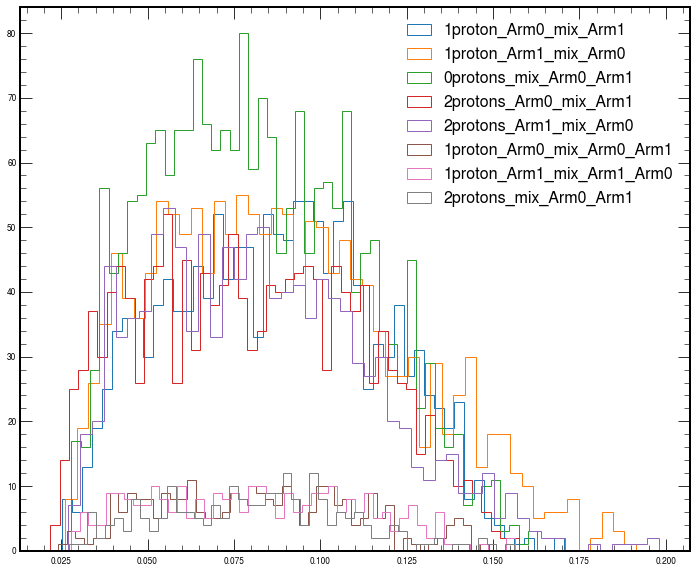

In [304]:
label_ = "GGToWW-AQGC-A0W1e-6"
fig = plt.figure( figsize=(12,10) )
for key_ in df_signals_protons_multiRP_out_acceptance_misreconstructed[ label_ ]:
    print ( key_ )
    df__ = df_signals_protons_multiRP_out_acceptance_misreconstructed[ label_ ][ key_ ]
    plt.hist( df__[ 'xi' ], histtype='step', bins=50, label=key_ )
plt.legend( loc='best', fontsize=16 )

In [311]:
label_ = "GGToWW-AQGC-A0W1e-6"
columns_ = df_signals_protons_multiRP_index[ label_ ].columns
columns_eff_ = columns_[ [ key_[ : len('eff') ] == 'eff' for key_ in columns_ ] ]

columns_drop_ = [ "xi", "thx", "thy", "t", "ismultirp", "rpid", "arm", "random",
                  "trackx1", "tracky1", "trackpixshift1", "rpid1",
                  "trackx2", "tracky2", "trackpixshift2", "rpid2" ]
columns_drop_eff_ = columns_drop_.copy()
columns_drop_eff_.extend( columns_eff_ )

df_signals_protons_multiRP_out_acceptance_misreconstructed_events = {}
for label_ in labels_signals:
    df_signals_protons_multiRP_out_acceptance_misreconstructed_events[ label_ ] = {}
    for key_ in df_signals_protons_multiRP_out_acceptance_misreconstructed[ label_ ]: 
        print ( key_ )
        columns_drop__ = columns_drop_ if key_ in ( '0protons_mix_Arm0_Arm1', '1proton_Arm0_mix_Arm0_Arm1', '1proton_Arm1_mix_Arm1_Arm0', '2protons_mix_Arm0_Arm1' ) else columns_drop_eff_
        df__ = df_signals_protons_multiRP_out_acceptance_misreconstructed[ label_ ][ key_ ]
        df_protons_multiRP_events__, df_protons_multiRP_index_2protons__ = process_events( df__, runOnMC=True, mix_protons=False, columns_drop=columns_drop__ )
        df_signals_protons_multiRP_out_acceptance_misreconstructed_events[ label_ ][ key_ ] = df_protons_multiRP_events__

1proton_Arm0_mix_Arm1
run  lumiblock  event   slice
1    10         966     0        True
                        0        True
     19         1810    0        True
                        0        True
     21         2094    0        True
                        0        True
     43         4257    0        True
                        0        True
     56         5597    0        True
                        0        True
     59         5826    0        True
                        0        True
     86         8575    0        True
                        0        True
     132        13188   0        True
                        0        True
     138        13776   0        True
                        0        True
     145        14421   0        True
                        0        True
     187        18621   0        True
                        0        True
                18665   0        True
                        0        True
     197        19614   0        Tru

run  lumiblock  event   slice
1    4          330     0        True
                        0        True
     17         1668    0        True
                        0        True
     78         7721    0        True
                        0        True
     93         9253    0        True
                        0        True
     103        10231   0        True
                        0        True
     108        10724   0        True
                        0        True
                10768   0        True
                        0        True
     113        11246   0        True
                        0        True
     130        12908   0        True
                        0        True
     131        13034   0        True
                        0        True
     157        15652   0        True
                        0        True
     173        17260   0        True
                        0        True
                17283   0        True
                    

run  lumiblock  event   slice
1    4          330     0        0.428070
     17         1668    0        0.451359
     78         7721    0        0.219219
     93         9253    0        0.382011
     103        10231   0        0.429655
     108        10724   0        0.425919
                10768   0        0.430405
     113        11246   0        0.429842
     130        12908   0        0.432164
     131        13034   0        0.424493
     157        15652   0        0.258578
     173        17260   0        0.418343
                17283   0        0.411119
     180        17914   0        0.445512
     184        18330   0        0.397941
     191        19081   0        0.432917
     209        20823   0        0.081860
     221        22053   0        0.425151
     233        23271   0        0.446816
     275        27476   0        0.441550
     282        28166   0        0.431550
     292        29166   0        0.161024
     344        34392   0        0.424209
    

run  lumiblock  event   slice
1    36         3502    0        True
                        0        True
     54         5302    0        True
                        0        True
     72         7145    0        True
                        0        True
     86         8531    0        True
                        0        True
     105        10427   0        True
                        0        True
     109        10818   0        True
                        0        True
     184        18365   0        True
                        0        True
     198        19795   0        True
                        0        True
     213        21265   0        True
                        0        True
     216        21557   0        True
                        0        True
     223        22299   0        True
                        0        True
     225        22407   0        True
                        0        True
     235        23417   0        True
                    

run  lumiblock  event   slice
1    29         2899    0        True
                        0        True
     48         4763    0        True
                        0        True
     50         4970    0        True
                        0        True
     70         6984    0        True
                        0        True
     96         9567    0        True
                        0        True
     153        15274   0        True
                        0        True
     160        15969   0        True
                        0        True
     171        17026   0        True
                        0        True
     185        18499   0        True
                        0        True
     200        19968   0        True
                        0        True
     209        20845   0        True
                        0        True
     245        24476   0        True
                        0        True
     246        24522   0        True
                    

run  lumiblock  event   slice
1    43         4257    0        True
                        0        True
     86         8575    0        True
                        0        True
     187        18621   0        True
                        0        True
                18665   0        True
                        0        True
     197        19614   0        True
                        0        True
     335        33421   0        True
                        0        True
     376        37578   0        True
                        0        True
     454        45390   0        True
                        0        True
     464        46345   0        True
                        0        True
     473        47285   0        True
                        0        True
     633        63247   0        True
                        0        True
     705        70452   0        True
                        0        True
     769        76894   0        True
                    

run  lumiblock  event   slice
1    173        17283   0        True
                        0        True
     221        22053   0        True
                        0        True
     282        28166   0        True
                        0        True
     347        34628   0        True
                        0        True
     426        42523   0        True
                        0        True
     475        47429   0        True
                        0        True
     516        51552   0        True
                        0        True
     699        69858   0        True
                        0        True
     826        82568   0        True
                        0        True
     827        82640   0        True
                        0        True
     895        89414   0        True
                        0        True
     897        89649   0        True
                        0        True
     908        90720   0        True
                    

run  lumiblock  event   slice
1    246        24522   0        True
                        0        True
     350        34969   0        True
                        0        True
     453        45291   0        True
                        0        True
     638        63744   0        True
                        0        True
     741        74074   0        True
                        0        True
     924        92306   0        True
                        0        True
     1115       111408  0        True
                        0        True
     1127       112689  0        True
                        0        True
     1133       113275  0        True
                        0        True
     1172       117167  0        True
                        0        True
     1198       119729  0        True
                        0        True
     1216       121548  0        True
                        0        True
     1334       133384  0        True
                    

run  lumiblock  event   slice
1    5          434     0        True
                        0        True
                493     0        True
                        0        True
     10         995     0        True
                        0        True
     15         1488    0        True
                        0        True
     22         2159    0        True
                        0        True
     26         2551    0        True
                        0        True
     46         4577    0        True
                        0        True
     75         7491    0        True
                        0        True
     93         9202    0        True
                        0        True
     94         9382    0        True
                        0        True
     98         9800    0        True
                        0        True
     116        11548   0        True
                        0        True
     121        12059   0        True
                    

run  lumiblock  event   slice
1    5          434     0        0.339563
                493     0        0.338457
     10         995     0        0.392493
     15         1488    0        0.390535
     22         2159    0        0.335554
     26         2551    0        0.297027
     46         4577    0        0.392285
     75         7491    0        0.350616
     93         9202    0        0.380696
     94         9382    0        0.346486
     98         9800    0        0.146989
     116        11548   0        0.386555
     121        12059   0        0.204400
     149        14805   0        0.386258
     155        15488   0        0.337534
     156        15507   0        0.337644
     159        15842   0        0.342316
     162        16107   0        0.390952
                16148   0        0.369877
     165        16407   0        0.328113
                16453   0        0.336479
     169        16837   0        0.390319
     176        17565   0        0.295088
    

run  lumiblock  event   slice
1    8          800     0        0.820389
     13         1219    0        0.517655
     16         1598    0        0.774272
     25         2403    0        0.788464
                2416    0        0.835029
     40         3955    0        0.800431
     43         4241    0        0.801934
     49         4860    0        0.479810
     56         5502    0        0.533470
     58         5788    0        0.829123
     60         5970    0        0.836059
     63         6249    0        0.845045
                6251    0        0.797082
     65         6447    0        0.791705
     67         6618    0        0.774924
     77         7608    0        0.776576
     78         7725    0        0.797773
     79         7900    0        0.794248
     94         9328    0        0.800856
     96         9556    0        0.788943
     100        9933    0        0.790297
     117        11656   0        0.787841
     130        12925   0        0.837636
    

run  lumiblock  event   slice
1    32         3140    0        1.0
                3171    0        1.0
     37         3612    0        1.0
     64         6346    0        1.0
     70         6987    0        1.0
     82         8145    0        1.0
     106        10523   0        1.0
     128        12795   0        1.0
     152        15138   0        1.0
     198        19744   0        1.0
     215        21456   0        1.0
     246        24599   0        1.0
     278        27759   0        1.0
     282        28169   0        1.0
     300        29928   0        1.0
     465        46461   0        1.0
     498        49765   0        1.0
     501        50016   0        1.0
     505        50459   0        1.0
     519        51828   0        1.0
     605        60424   0        1.0
     610        60983   0        1.0
     622        62191   0        1.0
     642        64135   0        1.0
     649        64834   0        1.0
     665        66440   0        1.0
     686

run  lumiblock  event   slice
1    1          85      0       -0.057634
     7          621     0        0.054316
     12         1146    0       -0.257478
     13         1269    0       -0.001281
     18         1709    0        0.082688
     19         1801    0        0.140848
     28         2788    0        0.228653
     51         5047    0        0.034613
     53         5280    0       -0.295632
     56         5583    0        0.034912
     68         6733    0        0.245720
     86         8600    0       -0.055745
     87         8683    0       -0.104346
     92         9108    0       -0.798362
     93         9264    0        0.239593
     96         9598    0       -0.122172
     98         9740    0       -0.089139
     116        11574   0        0.010052
     124        12331   0        0.125971
     126        12595   0        0.085401
     127        12675   0        0.163187
     131        13037   0        0.033288
     136        13502   0       -0.180070
    

run  lumiblock  event   slice
1    12         1101    0        1099.895508
                1146    0         898.592712
     53         5280    0        1118.587036
     56         5583    0        1223.256836
     57         5663    0        1212.970581
     64         6343    0        1158.875854
     69         6868    0         741.606445
     80         7965    0        1133.928589
     86         8584    0        1198.999634
                8600    0        1540.210449
     88         8793    0        1503.596313
     91         9053    0        1360.115845
     93         9228    0         986.876160
     97         9617    0        1046.467285
     99         9865    0        1548.835938
     107        10611   0         978.186951
     119        11862   0        1332.141602
     122        12110   0        1342.578247
     126        12595   0         907.576904
     128        12742   0        1002.093689
     130        12951   0        1546.989380
     131        13089   0

run  lumiblock  event   slice
1    5          434     0        True
                        0        True
     93         9202    0        True
                        0        True
     94         9382    0        True
                        0        True
     116        11548   0        True
                        0        True
     159        15842   0        True
                        0        True
     162        16107   0        True
                        0        True
     228        22709   0        True
                        0        True
     236        23536   0        True
                        0        True
     252        25147   0        True
                        0        True
     254        25358   0        True
                        0        True
     487        48693   0        True
                        0        True
     492        49170   0        True
                        0        True
     562        56132   0        True
                    

run  lumiblock  event   slice
1    25         2403    0        True
                        0        True
                2416    0        True
                        0        True
     63         6249    0        True
                        0        True
     65         6447    0        True
                        0        True
     79         7900    0        True
                        0        True
     130        12925   0        True
                        0        True
     133        13237   0        True
                        0        True
     139        13891   0        True
                        0        True
     140        13984   0        True
                        0        True
     142        14192   0        True
                        0        True
     154        15358   0        True
                        0        True
     208        20788   0        True
                        0        True
     219        21869   0        True
                    

run  lumiblock  event   slice
1    25         2403    0        0.211536
                2416    0        0.164971
     63         6249    0        0.154955
     65         6447    0        0.208295
     79         7900    0        0.205752
     130        12925   0        0.162364
     133        13237   0        0.207207
     139        13891   0        0.253108
     140        13984   0        0.194897
     142        14192   0        0.203429
     154        15358   0        0.157551
     208        20788   0        0.194247
     219        21869   0        0.207580
     247        24667   0        0.168058
     264        26359   0        0.196701
     266        26599   0        0.207942
     283        28257   0        0.198185
     288        28709   0        0.204616
     293        29286   0        0.219396
     469        46879   0        0.210104
     526        52570   0        0.167103
     561        56010   0        0.164658
     578        57738   0        0.199372
    

run  lumiblock  event   slice
1    5          478     0        True
                        0        True
     6          582     0        True
                        0        True
     7          624     0        True
                        0        True
     15         1487    0        True
                        0        True
     18         1772    0        True
                        0        True
     19         1817    0        True
                        0        True
     22         2136    0        True
                        0        True
     29         2803    0        True
                        0        True
                2873    0        True
                        0        True
     36         3514    0        True
                        0        True
     39         3855    0        True
                        0        True
     41         4004    0        True
                        0        True
                4055    0        True
                    

run  lumiblock  event   slice
1    5          478     0        0.339854
     6          582     0        0.390173
     7          624     0        0.327919
     15         1487    0        0.385253
     18         1772    0        0.340048
     19         1817    0        0.395003
     22         2136    0        0.259294
     29         2803    0        0.394919
                2873    0        0.389663
     36         3514    0        0.342166
     39         3855    0        0.338620
     41         4004    0        0.367328
                4055    0        0.388755
     42         4140    0        0.342132
     44         4384    0        0.347184
     47         4626    0        0.365718
     51         5025    0        0.392520
                5045    0        0.385632
     52         5118    0        0.336231
     55         5430    0        0.392380
     60         5962    0        0.337469
     62         6124    0        0.393057
     66         6577    0        0.206591
    

run  lumiblock  event   slice
1    6          580     0        0.785858
     7          612     0        0.597261
                657     0        0.786686
                695     0        0.782058
     10         940     0        0.779264
     11         1096    0        0.765934
     14         1350    0        0.838382
     25         2437    0        0.804625
     27         2654    0        0.801903
     28         2739    0        0.796007
     30         2906    0        0.776227
                2914    0        0.701986
     32         3191    0        0.794392
     34         3344    0        0.790873
                3394    0        0.846831
     36         3526    0        0.832345
     42         4157    0        0.792155
     46         4591    0        0.819972
                4594    0        0.849859
     51         5024    0        0.847064
     52         5163    0        0.843039
     54         5340    0        0.795522
     55         5421    0        0.779685
    

run  lumiblock  event   slice
1    15         1412    0        0.062530
     16         1504    0       -0.165009
     17         1635    0        0.096087
     40         4000    0        0.439582
     44         4370    0        0.367106
     69         6828    0        0.004688
     70         6950    0       -0.031287
     81         8021    0       -0.548459
     92         9121    0       -0.258770
     98         9773    0       -0.385895
     101        10064   0       -0.075477
     108        10795   0        0.219051
     111        11071   0        0.116902
     115        11430   0       -0.164887
     117        11648   0        0.012691
     128        12764   0        0.034259
     136        13582   0       -0.043673
     141        14006   0       -0.209904
                14041   0       -0.282472
     158        15755   0       -0.163955
     165        16498   0       -0.343194
     182        18135   0       -0.047656
     196        19517   0       -0.313493
    

run  lumiblock  event   slice
1    1          24      0         892.309814
                32      0        1220.498169
     8          771     0        1218.324585
     10         956     0        1241.785767
     11         1027    0         753.539856
     12         1170    0        1667.606079
     14         1324    0        1331.603516
     16         1566    0         961.277649
     35         3467    0         834.536926
     36         3521    0        1462.960938
     45         4415    0        1228.958130
                4429    0         910.857483
     47         4700    0        1753.868530
     48         4730    0         633.290649
     54         5380    0        1077.213867
     56         5527    0        1227.694458
     64         6315    0        1149.990601
                6317    0        1145.755005
     66         6575    0        1553.125732
     67         6680    0        1544.490723
     69         6839    0        1037.322266
     71         7062    0

run  lumiblock  event   slice
1    1          24      0        True
                        0        True
     4          344     0        True
                        0        True
     13         1209    0        True
                        0        True
     20         1957    0        True
                        0        True
     21         2077    0        True
                        0        True
     27         2645    0        True
                        0        True
     36         3576    0        True
                        0        True
     39         3882    0        True
                        0        True
     43         4241    0        True
                        0        True
     64         6317    0        True
                        0        True
                6359    0        True
                        0        True
     65         6402    0        True
                        0        True
     83         8297    0        True
                    

run  lumiblock  event   slice
1    1          24      0        0.183362
     4          344     0        0.292247
     13         1209    0        0.347309
     20         1957    0        0.196568
     21         2077    0        0.148951
     27         2645    0        0.178572
     36         3576    0        0.149835
     39         3882    0        0.162307
     43         4241    0        0.189787
     64         6317    0        0.134800
                6359    0        0.181405
     65         6402    0        0.227876
     83         8297    0        0.140345
     84         8304    0        0.138234
                8356    0        0.183490
                8385    0        0.168321
     86         8598    0        0.168442
     90         8958    0        0.143162
     96         9561    0        0.146890
     100        9901    0        0.099665
     101        10045   0        0.165485
     103        10203   0        0.236785
     113        11204   0        0.177135
    

run  lumiblock  event   slice
1    29         2873    0        0.322844
     47         4626    0        0.364865
     51         5045    0        0.329975
     62         6124    0        0.317453
     76         7596    0        0.396234
     87         8648    0        0.314441
     96         9573    0        0.322643
     119        11854   0        0.422455
     159        15851   0        0.403826
     160        15982   0        0.372254
     179        17875   0        0.407435
     184        18304   0        0.402182
     211        21071   0        0.408926
     222        22174   0        0.319640
     225        22429   0        0.335887
     226        22562   0        0.315148
     244        24391   0        0.332728
     255        25406   0        0.328029
     261        26051   0        0.321462
     263        26289   0        0.401781
     268        26740   0        0.584945
     271        27094   0        0.414289
     273        27290   0        0.389798
    

run  lumiblock  event   slice
1    6          580     0        0.230945
     7          612     0        0.540637
     11         1096    0       -0.485447
     27         2654    0       -0.046744
     51         5024    0       -0.076000
     52         5163    0       -0.287813
     60         5928    0        0.300421
     67         6612    0        0.207227
     73         7263    0       -0.497269
     77         7640    0        0.033459
     83         8266    0        0.291942
     84         8337    0       -0.010898
     93         9249    0        0.006394
     151        15018   0        0.064142
     186        18563   0       -0.114315
                18568   0        0.033673
     187        18689   0       -0.009834
     188        18703   0       -0.250442
     191        19038   0       -0.027271
     194        19396   0       -0.203397
     209        20895   0        0.286338
     227        22634   0       -0.485838
     236        23598   0       -0.227839
    

run  lumiblock  event   slice
1    1          24      0         855.443542
     64         6317    0         842.347717
     84         8385    0        1037.035400
     96         9561    0         866.401489
     125        12464   0        1051.455078
     144        14389   0        1445.122925
     181        18087   0        1611.501221
     205        20461   0         838.998474
     235        23465   0        1141.847534
     270        26971   0         729.893921
     274        27342   0        1303.773682
     301        30021   0         877.961975
     304        30357   0        1169.695679
     305        30440   0        1553.335327
     315        31460   0         916.364502
     337        33662   0        1296.449951
     383        38214   0        1170.092773
     398        39772   0         906.110718
     452        45102   0         960.550171
     460        45915   0        1371.517090
     470        46994   0        1252.479980
     477        47639   0

### Select events

In [318]:
selection_keys_signals = {}
selections_signals = {}
for label_ in labels_signals:
    print ( df_signals_protons_multiRP_events[ label_ ].shape[0] )
    df_signals_protons_multiRP_events[ label_ ], selection_keys_signals[ label_ ], selections_signals[ label_ ] = select_events( df_signals_protons_multiRP_events[ label_ ] )
    print ( df_signals_protons_multiRP_events[ label_ ].shape[0] )

3687


/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


1537
6368
2848
14799
7016


In [319]:
print ( selection_keys_signals )
print ( selections_signals )

{'GGToWW-AQGC-A0W1e-6': ['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks'], 'GGToWW-AQGC-A0W2e-6': ['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks'], 'GGToWW-AQGC-A0W5e-6': ['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']}
{'GGToWW-AQGC-A0W1e-6': {'All': 3687, 'Muon': 3687, 'Jet': 3687, 'Jet_Muon': 3685, 'MET': 3290, 'Jet_MET': 3178, 'PrunedMass': 2311, 'Tau21': 2133, 'BJet_Veto': 2133, 'Xi_CMS': 2130, 'WLeptonic': 2069, 'Jet_WLeptonic': 2069, 'MWW': 2047, 'ExtraTracks': 1537}, 'GGToWW-AQGC-A0W2e-6': {'All': 6368, 'Muon': 6368, 'Jet': 6368, 'Jet_Muon': 6367, 'MET': 5782, 'Jet_MET': 5528, 'PrunedMass': 4135, 'Tau21': 3827, 'BJet_Veto': 3827, 'Xi_CMS': 3820, 'WLeptonic': 3745, 'Jet_WLeptoni

In [320]:
df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events = {}
for label_ in labels_signals:
    df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ] = {}
    for key_ in df_signals_protons_multiRP_out_acceptance_misreconstructed_events[ label_ ]: 
        print ( key_ )
        df_events__ = df_signals_protons_multiRP_out_acceptance_misreconstructed_events[ label_ ][ key_ ]
        print ( df_events__.shape[0] )
        df_selected_events__, selection_keys__, selections__ = select_events( df_events__ )
        print ( df_selected_events__.shape[0] )
        print ( selection_keys__ )
        print ( selections__ )
        df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ][ key_ ] = df_selected_events__

1proton_Arm0_mix_Arm1
734
286
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 734, 'Muon': 734, 'Jet': 734, 'Jet_Muon': 734, 'MET': 663, 'Jet_MET': 640, 'PrunedMass': 449, 'Tau21': 413, 'BJet_Veto': 413, 'Xi_CMS': 385, 'WLeptonic': 367, 'Jet_WLeptonic': 367, 'MWW': 356, 'ExtraTracks': 286}
1proton_Arm1_mix_Arm0
763
319
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 763, 'Muon': 763, 'Jet': 763, 'Jet_Muon': 763, 'MET': 705, 'Jet_MET': 673, 'PrunedMass': 494, 'Tau21': 452, 'BJet_Veto': 451, 'Xi_CMS': 431, 'WLeptonic': 422, 'Jet_WLeptonic': 422, 'MWW': 415, 'ExtraTracks': 319}
0protons_mix_Arm0_Arm1
196
82
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 196, 'M

290
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 633, 'Muon': 633, 'Jet': 633, 'Jet_Muon': 633, 'MET': 602, 'Jet_MET': 566, 'PrunedMass': 440, 'Tau21': 396, 'BJet_Veto': 396, 'Xi_CMS': 373, 'WLeptonic': 370, 'Jet_WLeptonic': 370, 'MWW': 370, 'ExtraTracks': 290}
1proton_Arm1_mix_Arm1_Arm0
1010
488
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 1010, 'Muon': 1010, 'Jet': 1010, 'Jet_Muon': 1010, 'MET': 960, 'Jet_MET': 916, 'PrunedMass': 718, 'Tau21': 652, 'BJet_Veto': 652, 'Xi_CMS': 607, 'WLeptonic': 602, 'Jet_WLeptonic': 602, 'MWW': 600, 'ExtraTracks': 488}
2protons_mix_Arm0_Arm1
480
219
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 480, 'Muon': 480, 'Jet

In [322]:
import json
samples_info = json.load( open( 'samples_info.json' ) )
samples_info

{'QCD_Pt_170to300_TuneCP5_13TeV_pythia8': [29829920.0, 103500, 2],
 'ExclusiveWW_a0w1e-6-SingleLepton-2017': [15000.0, 0.062086, 6],
 'GGToWW_bSM-A0W5e-6_13TeV-fpmc-herwig6': [993000.0, 0.148132, 6],
 'GGToWWToJJENu_PtL-15_13TeV-fpmc-herwig6': [295401.0, 0.0049534, 1],
 'QCD_Pt_1800to2400_TuneCP5_13TeV_pythia8': [2923941.0, 0.08743, 2],
 'DYJetsToLL_1J_TuneCP5_13TeV-amcatnloFXFX-pythia8': [95629091.0, 859.59, 12],
 'GGToWW_bSM-ACW5e-6_13TeV-fpmc-herwig6': [99500.0, 0.0487, 6],
 'QCD_Pt-300to470_MuEnrichedPt5_TuneCP5_13TeV_pythia8': [15679722.0,
  797.3526899999999,
  2],
 'ZZ_TuneCP5_13TeV-pythia8': [1949768.0, 16.523, 3],
 'QCD_Pt-170to300_MuEnrichedPt5_TuneCP5_13TeV_pythia8': [46438676.0,
  8654.49315,
  2],
 'WJetsToLNu_HT-1200To2500_TuneCP5_13TeV-madgraphMLM-pythia8': [20258624.0,
  1.02333,
  862],
 'W1JetsToLNu_LHEWpT_100-150_TuneCP5_13TeV-amcnloFXFX-pythia8': [73508344.0,
  286.1,
  862],
 'ST_t-channel_antitop_4f_inclusiveDecays_TuneCP5_13TeV-powhegV2-madspin-pythia8': [3939990

In [323]:
lumi = np.sum( list( lumi_periods.values() ) )
print ( lumi )

#labels_signals = [ "GGToWW-AQGC-test-A0W1e-6", "GGToWW-AQGC-test-A0W2e-6", "GGToWW-AQGC-test-A0W5e-6" ]
sample_names = {}
sample_names[ "GGToWW-AQGC-A0W1e-6" ] = "GGToWW_bSM-A0W1e-6_13TeV-fpmc-herwig6"
sample_names[ "GGToWW-AQGC-A0W2e-6" ] = "GGToWW_bSM-A0W2e-6_13TeV-fpmc-herwig6"
sample_names[ "GGToWW-AQGC-A0W5e-6" ] = "GGToWW_bSM-A0W5e-6_13TeV-fpmc-herwig6"

norm_factors = {}
for label_ in labels_signals:
    print ( label_ )
    sample_nevents_, sample_cross_section_, _ = samples_info[ sample_names[ label_ ] ]
    norm_factors[ label_ ] = np.array( [ lumi / ( sample_nevents_ ), sample_cross_section_*1000, 1.0 ] )
    print ( samples_info[ sample_names[ label_] ] )
    print ( norm_factors[ label_ ] )
    norm_factors_product_ = np.product( norm_factors[ label_ ] )
    df_signals_protons_multiRP_events[ label_ ].loc[ :, "norm" ] = norm_factors_product_
    for key_ in df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ]:
        print ( key_ )
        df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ][ key_ ].loc[ :, "norm" ] = norm_factors_product_

37.190432966
[993700.0, 0.0453974, 6]
[3.74262181e-05 4.53974000e+01 1.00000000e+00]
1proton_Arm0_mix_Arm1


/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


1proton_Arm1_mix_Arm0
0protons_mix_Arm0_Arm1
2protons_Arm0_mix_Arm1
2protons_Arm1_mix_Arm0
1proton_Arm0_mix_Arm0_Arm1
1proton_Arm1_mix_Arm1_Arm0
2protons_mix_Arm0_Arm1
[880000.0, 0.0583158, 6]
[4.22618556e-05 5.83158000e+01 1.00000000e+00]
1proton_Arm0_mix_Arm1
1proton_Arm1_mix_Arm0
0protons_mix_Arm0_Arm1
2protons_Arm0_mix_Arm1
2protons_Arm1_mix_Arm0
1proton_Arm0_mix_Arm0_Arm1
1proton_Arm1_mix_Arm1_Arm0
2protons_mix_Arm0_Arm1
[993000.0, 0.148132, 6]
[3.74526012e-05 1.48132000e+02 1.00000000e+00]
1proton_Arm0_mix_Arm1
1proton_Arm1_mix_Arm0
0protons_mix_Arm0_Arm1
2protons_Arm0_mix_Arm1
2protons_Arm1_mix_Arm0
1proton_Arm0_mix_Arm0_Arm1
1proton_Arm1_mix_Arm1_Arm0
2protons_mix_Arm0_Arm1


In [324]:
label_ = "GGToWW-AQGC-A0W5e-6"

print ( df_signals_protons_multiRP_events[ label_ ].columns )
df_signals_protons_multiRP_events[ label_ ]
# df_signals_protons_multiRP_events[ label_ ][ ["dphiWW", "deltaPhi_jet_Wlep"] ]

Index(['jet0_pt', 'jet0_eta', 'jet0_phi', 'jet0_energy', 'jet0_mass',
       'jet0_corrmass', 'jet0_tau1', 'jet0_tau2', 'jet0_vertexz', 'muon0_pt',
       'muon0_eta', 'muon0_phi', 'muon0_energy', 'muon0_charge', 'muon0_iso',
       'muon0_dxy', 'muon0_dz', 'met', 'met_x', 'met_y', 'met_phi',
       'nVertices', 'num_bjets_ak8', 'num_bjets_ak4', 'num_jets_ak4',
       'pfcand_nextracks', 'pfcand_nextracks_noDRl', 'recoMWhad', 'recoMWlep',
       'recoMWW', 'recoRapidityWW', 'dphiWW', 'WLeptonicPt', 'WLeptonicEta',
       'WLeptonicPhi', 'pileupWeight', 'mc_pu_trueinteractions', 'mcWeight',
       'xlow', 'xhigh', 'ylow', 'yhigh', 'sf_muon_id', 'MX', 'YX',
       'diffMWW_MX', 'ratioMWW_MX', 'shiftedRatioMWW_MX', 'diffYWW_YX',
       'eff_proton_all_weighted', 'eff_all_weighted', 'deltaPhi_jet_muon',
       'deltaEta_jet_muon', 'deltaR_jet_muon', 'deltaPhi_jet_met',
       'deltaPhi_jet_Wlep', 'jet0_tau21', 'xiCMS_45', 'xiCMS_56', 'norm'],
      dtype='object')


jet0_pt  jet0_eta  jet0_phi  jet0_energy  \
run lumiblock event  slice                                                
1   6049      104823 0      452.068115 -1.435060 -2.165500  1008.722229   
              104872 0      293.328430  1.216596 -2.577840   546.527954   
    6051      105004 0      434.371490  0.182227  1.019939   449.743011   
              105090 0      722.540283 -0.183093  1.128231   743.254578   
    6055      105434 0      559.050720  0.070478  2.299587   567.419312   
              105438 0      636.379700  0.544857 -1.580128   739.750488   
    6056      105583 0      613.628723 -0.823772  0.281126   843.196838   
              105577 0      529.907166 -0.247067  1.897167   560.596924   
    6057      105633 0      281.976471  0.539512  1.790467   334.587402   
    6058      105791 0      327.286499  1.283385  0.073566   643.324280   
    6060      105982 0      265.334839  0.386013 -2.068118   300.402344   
    6061      106048 0      383.615692 -0.059350 -0.649158   400.063232   
              106049 0      288.157501 -0.055869 -2.998290   302.154938   
              106063 0      619.001770 -0.504308  2.966167   707.317505   
              106080 0      474.851959 -0.828651 -0.455058   655.492432   
    6063      106285 0      297.829468  1.537439 -1.944738   731.483276   
    6064      106346 0      464.074524  0.138415 -1.108102   482.639618   
    6066      106579 0      421.796783 -0.603820  1.470948   509.514221   
    6067      106685 0      600.792847  0.216461  2.654944   629.864441   
    6068      106739 0      594.177795 -0.486774  0.240360   674.644836   
              106748 0      351.694458 -0.565503  2.818214   420.804779   
    6069      106832 0      393.123932  0.615333  2.296102   480.539856   
              106884 0      667.963379  0.421861 -0.455485   735.918091   
    6072      107104 0      352.809082 -0.313963  1.020891   382.446564   
              107196 0      685.035950 -0.362036  2.761556   736.763794   
    6076      107534 0      430.237579 -0.192955  2.201974   447.399780   
    6080      107988 0      563.257385  0.157225 -1.278659   581.888489   
    6083      108209 0      826.888123  0.326966  1.478339   879.378235   
    6084      108378 0      714.591980 -0.381608  2.320918   773.726685   
    6085      108436 0      882.642151 -0.108598  2.060721   897.612244   
...                                ...       ...       ...          ...   
    9663      466280 0      528.319153 -0.205146 -1.805852   552.093628   
              466296 0      543.908203 -0.323257  1.084497   581.249573   
    9664      466354 0      840.999756 -0.102392  0.155223   856.755920   
    9666      466565 0      533.936890 -0.686043  0.382273   670.705017   
              466574 0      539.635864 -1.058616  1.388102   877.501587   
    9668      466777 0      660.736572 -0.096597 -0.925626   673.144592   
    9670      466975 0      580.268066 -0.501627  2.753347   661.476929   
    9671      467074 0      376.136047 -1.239877  0.639137   709.945312   
    9672      467137 0      340.045166 -0.120427 -2.545356   350.503204   
              467173 0      552.430359 -0.464498 -0.022843   623.678223   
    9673      467213 0      556.554382  0.246771  0.311400   583.564209   
              467279 0      374.918793 -0.104387  1.759353   389.309021   
    9675      467413 0      515.312866  0.630789 -1.333526   630.154419   
    9677      467648 0      611.923706  0.870940  3.079736   866.457947   
              467662 0      319.591431 -0.066410  0.413671   335.565979   
              467681 0      606.182312 -0.715181  3.124832   776.644592   
    9679      467818 0      419.146942  1.013858 -2.885548   660.391235   
              467887 0      711.078491 -0.138597  2.074653   729.612671   
    9680      467921 0      537.413757 -1.124804 -2.080996   921.570862   
    9683      468236 0      504.050049  0.435157  2.825259   561.000549   
    9684      468327 0      448.380463  0.930395 -0.7392

In [325]:
labels_samples = {
    "GGToWW-AQGC-A0W1e-6": r"$\gamma\gamma \to WW \quad a_0^W=1e^{-6}$",
    "GGToWW-AQGC-A0W2e-6": r"$\gamma\gamma \to WW \quad a_0^W=2e^{-6}$",
    "GGToWW-AQGC-A0W5e-6": r"$\gamma\gamma \to WW \quad a_0^W=5e^{-6}$"
}

weights_mc = {}
weights_out_acceptance_misreconstructed = {}
for label_ in labels_signals:
    print ( label_ )
    weights_mc[ label_ ] = ( df_signals_protons_multiRP_events[ label_ ][ "norm" ] * 
                             df_signals_protons_multiRP_events[ label_ ][ "pileupWeight" ] *
                             df_signals_protons_multiRP_events[ label_ ][ "sf_muon_id" ] *
                             df_signals_protons_multiRP_events[ label_ ][ "eff_all_weighted" ] )
    weights_out_acceptance_misreconstructed[ label_ ] = {}
    for key_ in df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ]:
        print ( key_ )
        df_selected_events__ = df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ][ key_ ]
        weights_out_acceptance_misreconstructed[ label_ ][ key_ ] = ( df_selected_events__[ "norm" ] * 
                                                                      df_selected_events__[ "pileupWeight" ] *
                                                                      df_selected_events__[ "sf_muon_id" ] *
                                                                      df_selected_events__[ "eff_all_weighted" ] )
        
print ( weights_mc )
print ( weights_out_acceptance_misreconstructed )

1proton_Arm0_mix_Arm1
1proton_Arm1_mix_Arm0
0protons_mix_Arm0_Arm1
2protons_Arm0_mix_Arm1
2protons_Arm1_mix_Arm0
1proton_Arm0_mix_Arm0_Arm1
1proton_Arm1_mix_Arm1_Arm0
2protons_mix_Arm0_Arm1
1proton_Arm0_mix_Arm1
1proton_Arm1_mix_Arm0
0protons_mix_Arm0_Arm1
2protons_Arm0_mix_Arm1
2protons_Arm1_mix_Arm0
1proton_Arm0_mix_Arm0_Arm1
1proton_Arm1_mix_Arm1_Arm0
2protons_mix_Arm0_Arm1
1proton_Arm0_mix_Arm1
1proton_Arm1_mix_Arm0
0protons_mix_Arm0_Arm1
2protons_Arm0_mix_Arm1
2protons_Arm1_mix_Arm0
1proton_Arm0_mix_Arm0_Arm1
1proton_Arm1_mix_Arm1_Arm0
2protons_mix_Arm0_Arm1
{'GGToWW-AQGC-A0W1e-6': run  lumiblock  event   slice
1    2275       227457  0        0.000204
     2276       227579  0        0.000362
     2281       228042  0        0.000050
     2282       228117  0        0.000269
     2286       228503  0        0.000402
                228565  0        0.000172
     2297       229605  0        0.000046
     2298       229715  0        0.000179
     2299       229845  0        0.00029

{'GGToWW-AQGC-A0W1e-6': {'1proton_Arm0_mix_Arm1': run  lumiblock  event   slice
1    10         966     0        0.000260
     19         1810    0        0.000754
     56         5597    0        0.000576
     59         5826    0        0.000084
     86         8575    0        0.000713
     197        19614   0        0.000519
     214        21321   0        0.000832
     226        22505   0        0.000549
     253        25242   0        0.000739
     285        28418   0        0.000497
     315        31492   0        0.000516
     335        33421   0        0.000619
     356        35508   0        0.000829
     359        35842   0        0.000831
     381        38045   0        0.000841
     454        45354   0        0.000660
                45390   0        0.000515
     539        53883   0        0.000513
     594        59373   0        0.000676
     627        62652   0        0.000714
     633        63247   0        0.000454
     710        70932   0        0.000

In [336]:
df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events_concat = {}
weights_out_acceptance_misreconstructed_concat = {}
for label_ in labels_signals:
    print ( label_ )
    df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events_concat[ label_ ] = pd.concat( df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ] )
    print ( df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events_concat[ label_ ].shape[0] )
    weights_out_acceptance_misreconstructed_concat[ label_ ] = pd.concat( weights_out_acceptance_misreconstructed[ label_ ] )
    print ( weights_out_acceptance_misreconstructed_concat[ label_ ] )

GGToWW-AQGC-A0W1e-6
1414
                        run  lumiblock  event   slice
0protons_mix_Arm0_Arm1  1    13         1257    0        0.001622
                             163        16224   0        0.002130
                             417        41626   0        0.001467
                             452        45108   0        0.002141
                             492        49160   0        0.002105
                             507        50632   0        0.001622
                             587        58648   0        0.001941
                             701        70053   0        0.000028
                             1024       102313  0        0.002054
                             1079       107899  0        0.002141
                             1107       110689  0        0.001467
                             1265       126458  0        0.002141
                             1477       147694  0        0.001417
                             1564       156348  0        0.0019

<ipython-input-336-093e928412d1>:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events_concat[ label_ ] = pd.concat( df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ] )


                        run  lumiblock  event   slice
0protons_mix_Arm0_Arm1  1    69         6828    0        0.006982
                             81         8021    0        0.000164
                             92         9121    0        0.007110
                             117        11648   0        0.004350
                             128        12764   0        0.006414
                             141        14041   0        0.004411
                             165        16498   0        0.006497
                             208        20733   0        0.005021
                             235        23485   0        0.005021
                             252        25118   0        0.008696
                             298        29741   0        0.006118
                             312        31187   0        0.006118
                             350        34939   0        0.006911
                             372        37193   0        0.006497
                      

(array([  1.,   2.,   2.,   4.,   4.,   8.,  13.,  16.,  20.,  21.,  37.,
         49.,  79.,  89., 108., 137., 184., 271., 359., 404., 536., 547.,
        384., 326., 289., 242., 252., 179., 178., 132., 138., 158., 126.,
        113., 102., 121., 102.,  91.,  74.,  71.,  61.,  63.,  56.,  47.,
         59.,  53.,  48.,  45.,  46.,  38.,  48.,  32.,  29.,  28.,  33.,
         31.,  25.,  15.,  24.,  28.,  26.,  14.,  13.,  17.,  18.,  14.,
         11.,  13.,   8.,   7.,   7.,   7.,   6.,   7.,   9.,   4.,   5.,
          4.,   8.,   5.,   3.,   2.,   2.,  11.,   2.,   1.,   3.,   2.,
          2.,   1.,   0.,   2.,   0.,   1.,   0.,   0.,   0.,   1.,   1.,
          1.]),
 array([2.5847814, 2.6103113, 2.6358411, 2.661371 , 2.6869009, 2.7124307,
        2.7379606, 2.7634904, 2.7890203, 2.8145502, 2.8400803, 2.8656101,
        2.89114  , 2.9166698, 2.9421997, 2.9677296, 2.9932594, 3.0187893,
        3.0443192, 3.069849 , 3.0953789, 3.1209087, 3.1464386, 3.1719685,
        3.1974983, 3.2

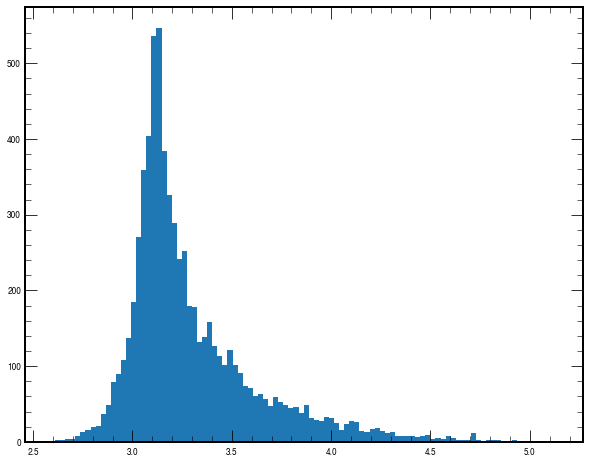

In [326]:
label_ = "GGToWW-AQGC-A0W5e-6"

fig = plt.figure( figsize=(10,8) )
# plt.hist( df_signals_protons_multiRP_events[ label_ ][ "deltaPhi_jet_muon" ], bins=100 )
# plt.hist( df_signals_protons_multiRP_events[ label_ ][ "deltaEta_jet_muon" ], bins=100 )
plt.hist( df_signals_protons_multiRP_events[ label_ ][ "deltaR_jet_muon" ], bins=100 )
# plt.hist( df_signals_protons_multiRP_events[ label_ ][ "deltaPhi_jet_met" ], bins=100 )
# plt.hist( df_signals_protons_multiRP_events[ label_ ][ "deltaPhi_jet_Wlep" ], bins=100 )

# plt.yscale( 'log' )

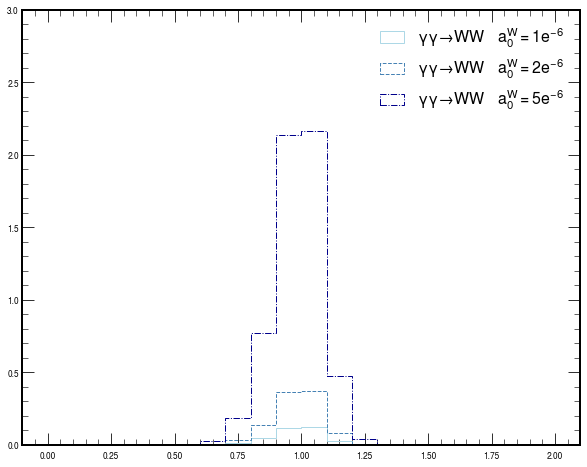

In [327]:
fig = plt.figure( figsize=(10,8) )

colors_ = [ "lightblue", "steelblue", "darkblue" ]
linestyles_ = [ "-", "--", "-." ]
for idx_, label_ in enumerate( labels_signals ):
    plt.hist( df_signals_protons_multiRP_events[ label_ ][ "ratioMWW_MX" ], weights=weights_mc[ label_ ],
              histtype='step', color=colors_[ idx_ ], linestyle=linestyles_[ idx_ ], label=labels_samples[ label_ ],
              bins=20, range=(0.,2.) )
plt.legend( loc='best', fontsize=16 )
    
plt.ylim( (0.,3.) )

if save_figures:
    plt.savefig( "plots/Ratio_MWW_MX_signals.pdf", bbox_inches='tight' )
    plt.savefig( "plots/Ratio_MWW_MX_signals.png", bbox_inches='tight' )

1proton_Arm0_mix_Arm1
1proton_Arm1_mix_Arm0
0protons_mix_Arm0_Arm1
2protons_Arm0_mix_Arm1
2protons_Arm1_mix_Arm0
1proton_Arm0_mix_Arm0_Arm1
1proton_Arm1_mix_Arm1_Arm0
2protons_mix_Arm0_Arm1


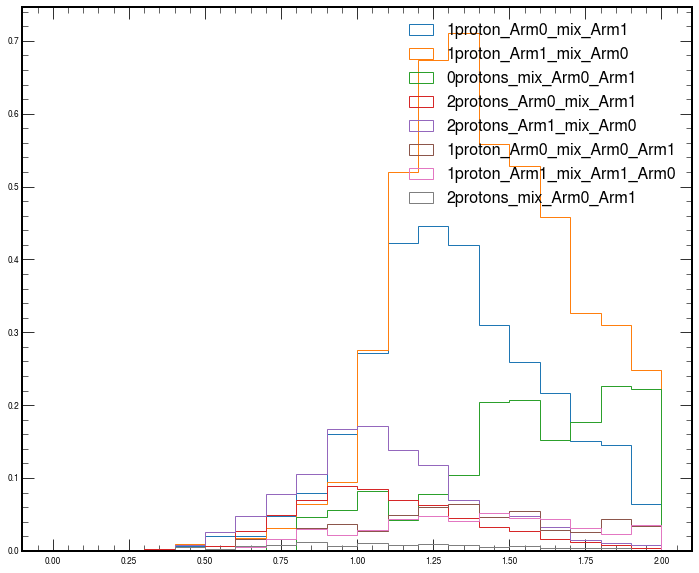

In [329]:
label_ = "GGToWW-AQGC-A0W5e-6"
fig = plt.figure( figsize=(12,10) )
for key_ in df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ]:
    print ( key_ )
    df_selected_events__ = df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ][ key_ ]
    plt.hist( df_selected_events__[ "ratioMWW_MX" ], weights=weights_out_acceptance_misreconstructed[ label_ ][ key_ ],
              histtype='step', label=key_,
              bins=20, range=(0.,2.) )
plt.legend( loc='best', fontsize=16 )

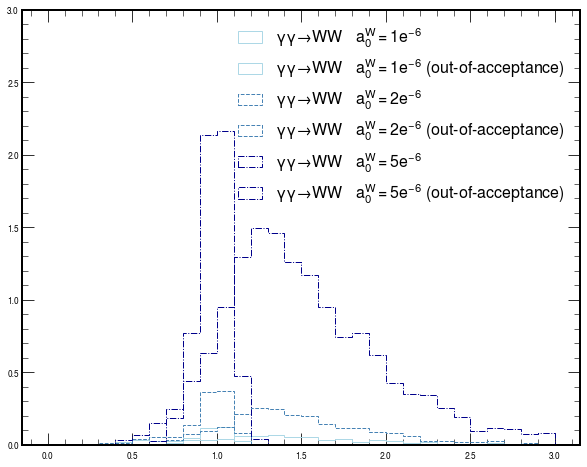

In [349]:
fig = plt.figure( figsize=(10,8) )

colors_ = [ "lightblue", "steelblue", "darkblue" ]
linestyles_ = [ "-", "--", "-." ]
for idx_, label_ in enumerate( labels_signals ):
    plt.hist( df_signals_protons_multiRP_events[ label_ ][ "ratioMWW_MX" ], weights=weights_mc[ label_ ],
              histtype='step', color=colors_[ idx_ ], linestyle=linestyles_[ idx_ ], label=labels_samples[ label_ ],
              bins=30, range=(0.,3.) )
    plt.hist( df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events_concat[ label_ ][ "ratioMWW_MX" ],
              weights=weights_out_acceptance_misreconstructed_concat[ label_ ],
              histtype='step', color=colors_[ idx_ ], linestyle=linestyles_[ idx_ ], label=( labels_samples[ label_ ] + " (out-of-acceptance)" ),
              bins=30, range=(0.,3.) )


plt.legend( loc='best', fontsize=16 )
    
plt.ylim( (0.,3.) )

if save_figures:
    plt.savefig( "plots/Ratio_MWW_MX_signals.pdf", bbox_inches='tight' )
    plt.savefig( "plots/Ratio_MWW_MX_signals.png", bbox_inches='tight' )